# Software analytics: Increase code review speed — impact on global colaboration in large projects

## Imports

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, kruskal, spearmanr, mannwhitneyu

## Load data

https://zenodo.org/records/3922907

In [177]:
def load_data():
    data = pd.read_csv('./data/new_pullreq.csv', header=0)
    return data
data = load_data()
data

,id,project_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,src_churn,test_churn,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
0,1,13708387,stylelint,stylelint,1,237,237.0,1,0,0,...,0,0,0,0,30.0,1,0.007948,0,237,0
1,2,100297899,Joaogarciadelima,checklistos,0,1410,NaN,1,0,0,...,0,2,0,0,597.0,0,0.830769,0,1410,0
2,3,93139005,binary-com,SmartCharts,1,4,4.0,1,0,0,...,0,0,0,0,2.0,0,0.314368,0,4,0
3,4,15059440,letsencrypt,boulder,1,52,52.0,1,9,104,...,0,0,0,0,1.0,0,0.117332,0,52,0
4,5,29684214,PyCQA,astroid,1,2414,2414.0,1,33,27,...,0,0,0,0,2.0,0,0.010753,0,2414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347932,3347933,30544060,Kronos-Integration,kronos-service-consul,1,9,9.0,1,0,0,...,0,0,0,0,2537.0,0,0.696970,0,9,0
3347933,3347934,1142,saltstack,salt,0,1165,NaN,1,10,0,...,0,1,0,0,42.0,0,0.056849,0,1165,0
3347934,3347935,31499094,mjmlio,mjml,1,8834,8834.0,2,6,0,...,0,8,0,0,597.0,0,0.002041,0,8834,0
3347935,3347936,55317,zotonic,zotonic,0,703,NaN,7,15,0,...,0,0,0,0,10.0,0,0.000732,0,703,0


In [178]:
for key in data.keys():
    print(key)

id
project_id
ownername
reponame
merged_or_not
lifetime_minutes
mergetime_minutes
num_commits
src_churn
test_churn
files_added
files_deleted
files_modified
files_changed
src_files
doc_files
other_files
num_commit_comments
num_issue_comments
num_comments
num_participants
sloc
team_size
perc_external_contribs
commits_on_files_touched
test_lines_per_kloc
test_cases_per_kloc
asserts_per_kloc
watchers
prev_pullreqs
requester_succ_rate
followers
churn_addition
churn_deletion
pr_comment_num
comment_num
perc_neg_emotion
perc_pos_emotion
perc_neu_emotion
part_num_issue
part_num_commit
part_num_pr
part_num_code
comment_conflict
hash_tag
at_tag
test_inclusion
description_length
bug_fix
ci_exists
ci_latency
ci_build_num
ci_test_passed
ci_failed_perc
ci_first_build_status
ci_last_build_status
language
fork_num
project_age
open_issue_num
pr_succ_rate
open_pr_num
first_response_time
pushed_delta
acc_commit_num
first_pr
account_creation_days
core_member
contrib_gender
contrib_country
contrib_affiliati

## Overview  & filtering of data of large projects

Number of projects: 11230


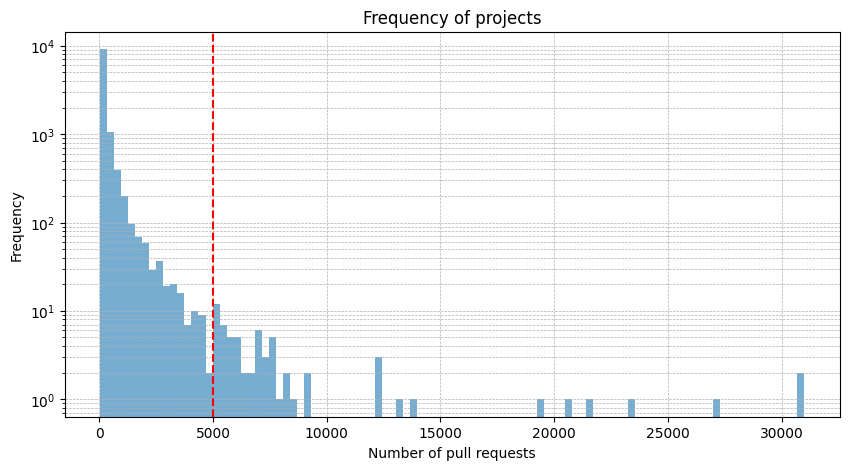

Mean number of pull requests: 298.12439893143363
Median number of pull requests: 96.0
Standard deviation of pull requests: 919.5069983233892
Maximum number of pull requests: 31007
Minimum number of pull requests: 20
Number of project with more than 5000 pull requests: 64


In [179]:
num_projects = data['project_id'].unique()
print('Number of projects: {}'.format(len(num_projects)))

projects = data['project_id'].value_counts()
project_ids = projects.index
num_pull_requests = projects.values

plt.figure(figsize=(10, 5))
plt.hist(num_pull_requests, bins=100, alpha=0.6, log=True)
plt.axvline(x=5000, color='r', linestyle='--')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Frequency of projects')
plt.xlabel('Number of pull requests')
plt.ylabel('Frequency')
plt.show()

print('Mean number of pull requests: {}'.format(np.mean(num_pull_requests)))
print('Median number of pull requests: {}'.format(np.median(num_pull_requests)))
print('Standard deviation of pull requests: {}'.format(np.std(num_pull_requests)))
print('Maximum number of pull requests: {}'.format(np.max(num_pull_requests)))  
print('Minimum number of pull requests: {}'.format(np.min(num_pull_requests)))

print('Number of project with more than 5000 pull requests: {}'.format(len(projects[num_pull_requests > 5000])))
filtered_project_ids_pr = projects[num_pull_requests > 5000].index

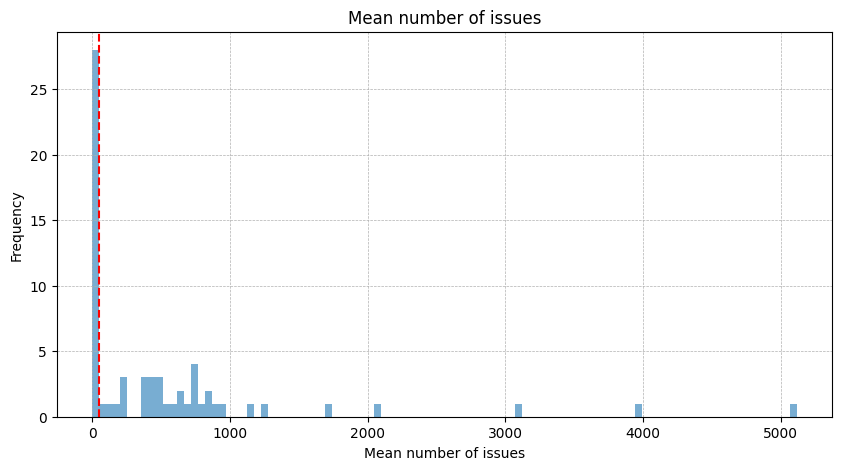

Mean number of issues: 533.6983378572712
Median number of issues: 223.95945367728729
Standard deviation of issues: 913.7737525230855
Maximum number of issues: 5114.82380743556
Minimum number of issues: 0.0
Number of project with more than 50 issues: 36


In [180]:
opened_issues = data[data['project_id'].isin(filtered_project_ids_pr)].groupby('project_id')['open_issue_num'].mean()

plt.figure(figsize=(10, 5))
plt.hist(opened_issues, bins=100, alpha=0.6)
plt.axvline(x=50, color='r', linestyle='--')
plt.xlabel('Mean number of issues')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean number of issues')
plt.show()

print('Mean number of issues: {}'.format(np.mean(opened_issues)))
print('Median number of issues: {}'.format(np.median(opened_issues)))
print('Standard deviation of issues: {}'.format(np.std(opened_issues)))
print('Maximum number of issues: {}'.format(np.max(opened_issues)))
print('Minimum number of issues: {}'.format(np.min(opened_issues)))

filtered_project_ids_issue = opened_issues[opened_issues > 50].index
print('Number of project with more than 50 issues: {}'.format(len(filtered_project_ids_issue)))

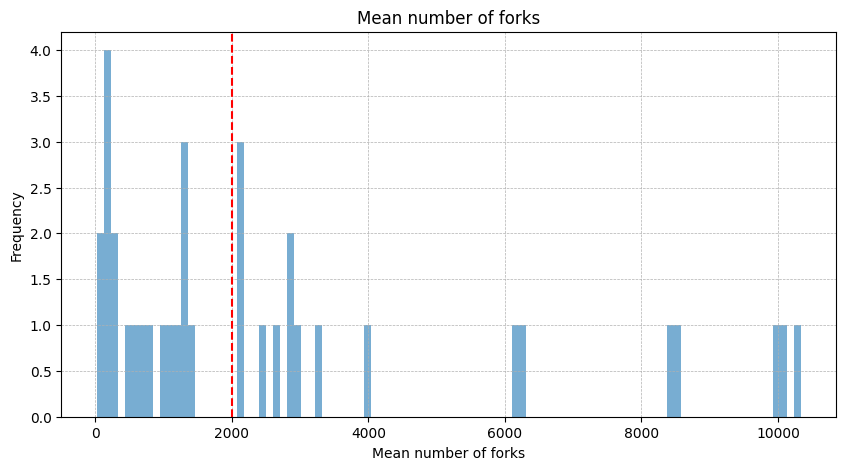

Mean number of forks: 2770.902336516114
Median number of forks: 1392.0325528649205
Standard deviation of number of forks: 3138.607774676715
Max number of forks: 10339.12191200117
Min number of forks: 17.9272476340694
Number of project with more than 2000 forks: 17


In [181]:
forks = data[data['project_id'].isin(filtered_project_ids_issue)].groupby('project_id')['fork_num'].mean()
plt.figure(figsize=(10, 5))
plt.hist(forks, bins=100, alpha=0.6)
plt.axvline(x=2000, color='r', linestyle='--')
plt.xlabel('Mean number of forks')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean number of forks')
plt.show()

print('Mean number of forks: {}'.format(forks.mean()))
print('Median number of forks: {}'.format(forks.median()))
print('Standard deviation of number of forks: {}'.format(forks.std()))
print('Max number of forks: {}'.format(forks.max()))
print('Min number of forks: {}'.format(forks.min()))

filtered_project_ids_forks = forks[forks > 2000].index
print('Number of project with more than 2000 forks: {}'.format(len(filtered_project_ids_forks)))

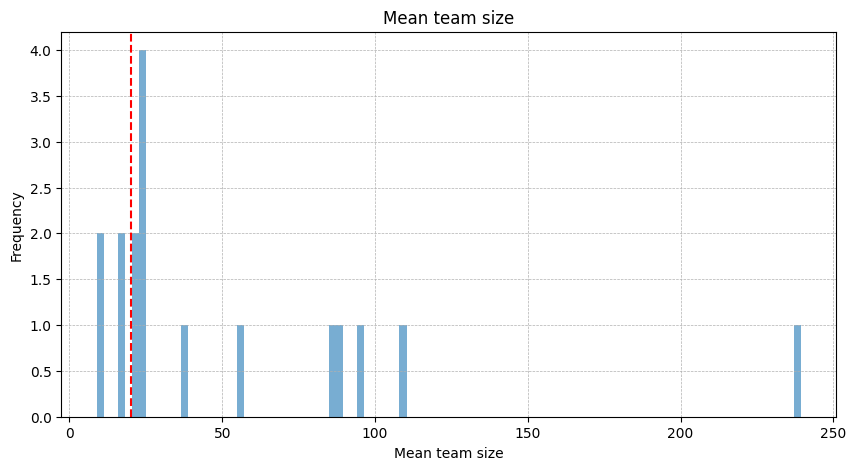

Mean team size: 53.18557840391017
Median team size: 24.21525700299157
Standard deviation: 58.21667776231618
Minimum team size: 8.850659264399722
Maximum team size: 239.44101739511768
More than 20 collaborators: 13


In [182]:

num_collaborators = data[data['project_id'].isin(filtered_project_ids_forks)].groupby('project_id')['team_size'].mean()

plt.figure(figsize=(10, 5))
plt.hist(num_collaborators, bins=100, alpha=0.6)
plt.axvline(x=20, color='r', linestyle='--')
plt.xlabel('Mean team size')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean team size')
plt.show()

print('Mean team size: {}'.format(num_collaborators.mean()))
print('Median team size: {}'.format(num_collaborators.median()))
print('Standard deviation: {}'.format(num_collaborators.std()))
print('Minimum team size: {}'.format(num_collaborators.min()))
print('Maximum team size: {}'.format(num_collaborators.max()))

filtered_project_ids_collab = num_collaborators[num_collaborators > 20].index
print('More than 20 collaborators: {}'.format(len(filtered_project_ids_collab)))


## Pre-processing of filtered data

In [183]:
print(data[data['project_id'].isin(filtered_project_ids_collab)]['reponame'].unique())
filtered_data = data[data['project_id'].isin(filtered_project_ids_collab)]
filtered_data

['scikit-learn' 'salt' 'metasploit-framework' 'kubernetes' 'react' 'node'
 'ansible' 'odoo' 'rails' 'matplotlib' 'ember.js' 'pandas' 'gatsby']


,id,project_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,src_churn,test_churn,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
30,31,5219,scikit-learn,scikit-learn,0,122459,NaN,3,201,504,...,1,8,199,2,60.0,0,0.000373,0,122459,0
34,35,1142,saltstack,salt,1,4534,4534.0,1,22,0,...,0,1,0,0,49.0,1,0.000622,0,4534,0
40,41,1142,saltstack,salt,1,983,983.0,1,193,0,...,0,0,0,0,3.0,0,0.000013,0,983,0
44,45,853,rapid7,metasploit-framework,1,131,131.0,1,2,0,...,0,0,0,0,159.0,0,0.000023,0,131,0
51,52,22091370,kubernetes,kubernetes,1,627,627.0,1,8,19,...,1,3,0,0,0.0,0,0.000459,0,627,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347814,3347815,48212908,pandas-dev,pandas,1,63531,63531.0,215,9804,13464,...,1,13,17,3,7.0,0,0.000274,1,10204,1
3347881,3347882,20078281,nodejs,node,1,11373,11373.0,4,16,0,...,1,9,0,0,197.0,0,0.012812,0,11373,0
3347882,3347883,853,rapid7,metasploit-framework,1,1248,1248.0,4,66,0,...,0,1,2,0,113.0,0,0.001935,0,1248,0
3347907,3347908,3905191,facebook,react,1,484,484.0,1,0,0,...,1,0,0,0,12.0,0,0.097158,0,484,0


C:\Users\kaitl\AppData\Local\Temp\ipykernel_14912\785752461.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['log_mergetime_minutes'] = np.log(filtered_data['mergetime_minutes'] + 1)
C:\Users\kaitl\AppData\Local\Temp\ipykernel_14912\785752461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['log_lifetime_minutes'] = np.log(filtered_data['lifetime_minutes'] + 1)


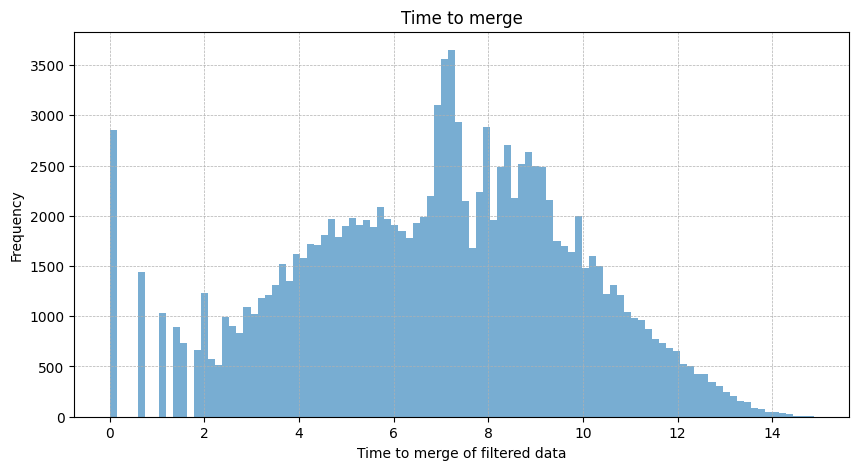

Shapiro-Wilk test for mergetime_minutes: W = 0.5146211076462931, p = 1.650947825244879e-79
Shapiro-Wilk test for log mergetime_minutes: W = 0.9807439995319932, p = 1.5887552726180007e-25


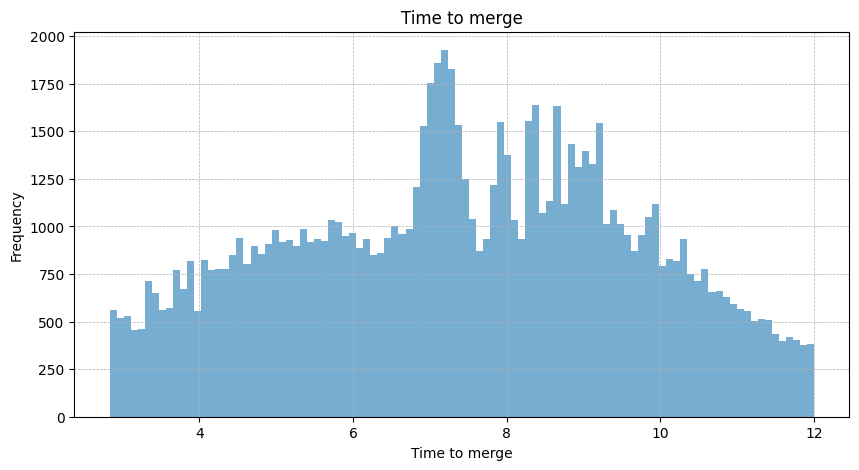

Number of pull requests before removing outliers: 186705
Number of pull requests after removing outliers: 93373


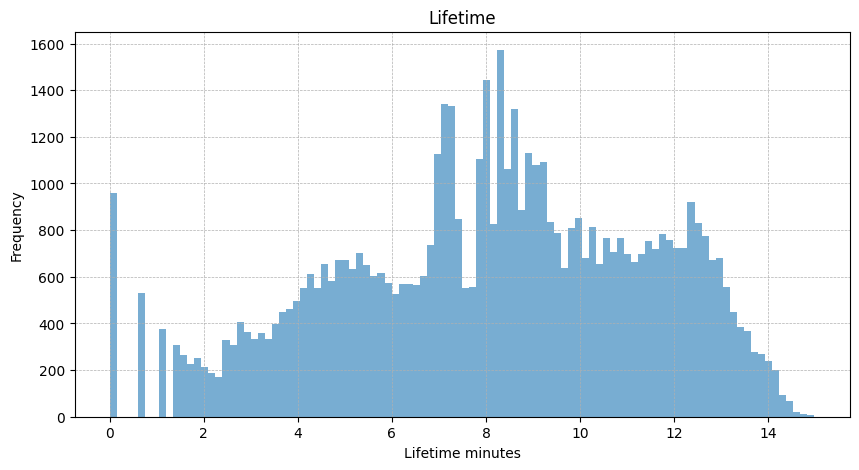

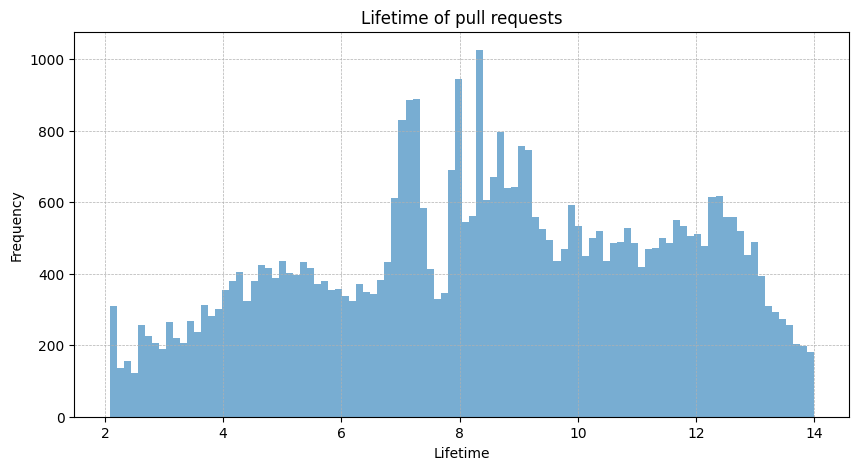

Shapiro-Wilk test for lifetime_minutes: W = 0.5085711212689942, p = 8.928182969098403e-80
Shapiro-Wilk test for log lifetime_minutes: W = 0.9751888154916766, p = 1.206118738787448e-28


In [184]:
filtered_data['log_mergetime_minutes'] = np.log(filtered_data['mergetime_minutes'] + 1)
filtered_data['log_lifetime_minutes'] = np.log(filtered_data['lifetime_minutes'] + 1)

# filtered_df['filtered_mergetime_minutes'] = np.exp(filtered_df['log_mergetime_minutes']) - 1
# merged data
plt.figure(figsize=(10, 5))
plt.hist(filtered_data['log_mergetime_minutes'], bins=100, alpha=0.6)
plt.xlabel('Time to merge of filtered data')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Time to merge')
plt.show()

Q1 = filtered_data['log_mergetime_minutes'].quantile(0.25)
Q3 = filtered_data['log_mergetime_minutes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

merged_data = filtered_data[(filtered_data['log_mergetime_minutes'] >= lower_bound) & (filtered_data['log_mergetime_minutes'] <= upper_bound)]
merged_data = merged_data[merged_data['mergetime_minutes'] > 15]
merged_data = merged_data[merged_data['files_changed'] > 0]
merged_data = merged_data[merged_data['src_churn'] > 0]
merged_data = merged_data[merged_data['log_mergetime_minutes'] <= 12]

sample = merged_data['mergetime_minutes'].sample(n=5000, random_state=1)
stat, p = shapiro(sample)
print('Shapiro-Wilk test for mergetime_minutes: W = {}, p = {}'.format(stat, p))
sample = merged_data['log_mergetime_minutes'].sample(n=5000, random_state=1)
stat, p = shapiro(sample)
print('Shapiro-Wilk test for log mergetime_minutes: W = {}, p = {}'.format(stat, p))

plt.figure(figsize=(10, 5))
plt.hist(merged_data['log_mergetime_minutes'], bins=100, alpha=0.6)
plt.xlabel('Time to merge')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Time to merge')
plt.show()

print('Number of pull requests before removing outliers: {}'.format(len(filtered_data)))
print('Number of pull requests after removing outliers: {}'.format(len(merged_data)))

# closed pull requests without merge
closed_data = filtered_data[(filtered_data['merged_or_not'] == 0) & (filtered_data['lifetime_minutes'].notna())]
plt.figure(figsize=(10, 5))
plt.hist(closed_data['log_lifetime_minutes'], bins=100, alpha=0.6)
plt.xlabel('Lifetime minutes')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Lifetime')
plt.show()

Q1 = filtered_data['log_lifetime_minutes'].quantile(0.25)
Q3 = filtered_data['log_lifetime_minutes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

closed_data = filtered_data[(filtered_data['merged_or_not'] == 0) & (filtered_data['log_lifetime_minutes'] >= lower_bound) & (filtered_data['log_lifetime_minutes'] <= upper_bound)]
closed_data = closed_data[closed_data['files_changed'] > 0]
closed_data = closed_data[closed_data['src_churn'] > 0]
closed_data = closed_data[(closed_data['log_lifetime_minutes'] > 2) & (closed_data['log_lifetime_minutes'] < 14)]

plt.figure(figsize=(10, 5))
plt.hist(closed_data['log_lifetime_minutes'], bins=100, alpha=0.6)
plt.xlabel('Lifetime')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Lifetime of pull requests')
plt.show()

sample = closed_data['lifetime_minutes'].sample(n=5000, random_state=1)
stat, p = shapiro(sample)
print('Shapiro-Wilk test for lifetime_minutes: W = {}, p = {}'.format(stat, p))
sample = closed_data['log_lifetime_minutes'].sample(n=5000, random_state=1)
stat, p = shapiro(sample)
print('Shapiro-Wilk test for log lifetime_minutes: W = {}, p = {}'.format(stat, p))

# Analysis of filtered data

## Gender

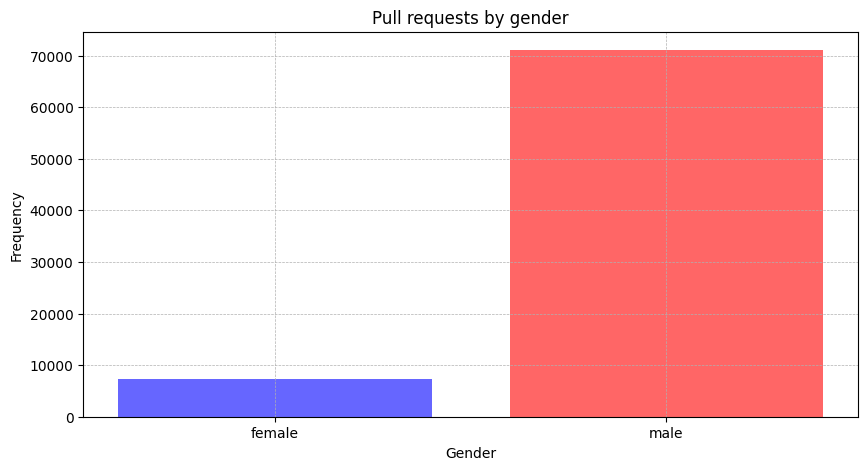

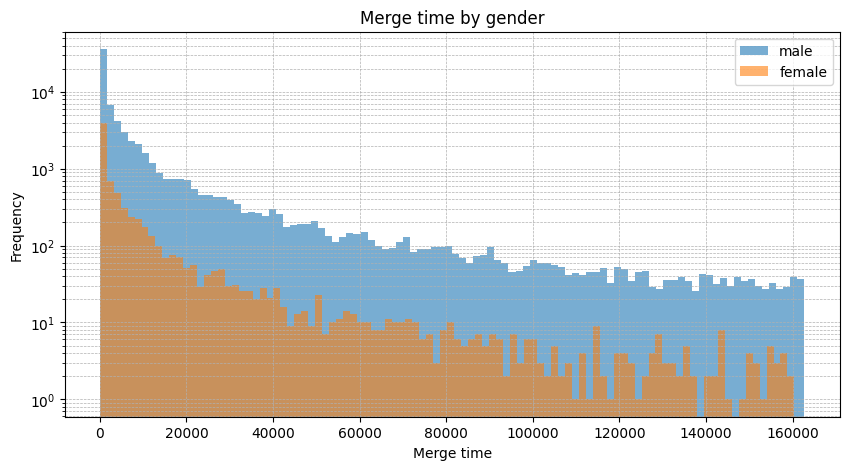

Shapiro-Wilk test for male contributors, merge time in minutes: W = 0.5055108824456924, p = 6.558426400751965e-80
Shapiro-Wilk test for female contributors, merge time in minutes: W = 0.477437708132993, p = 4.170094949962413e-81
Kruskal-Wallis H test, merge time in minutes: H = 10.878689441156633, p = 0.0009727705555336727
Mean merge time for male contributors: 11107.044200838704
Mean merge time for female contributors: 9336.398077964266
Median merge time for male contributors: 1579.0
Median merge time for female contributors: 1431.5
Standard deviation of merge time for male contributors: 23976.060207137994
Standard deviation of merge time for female contributors: 21233.26792611111
Maximum merge time for male contributors: 162737.0
Maximum merge time for female contributors: 160421.0
Minimum merge time for male contributors: 16.0
Minimum merge time for female contributors: 16.0


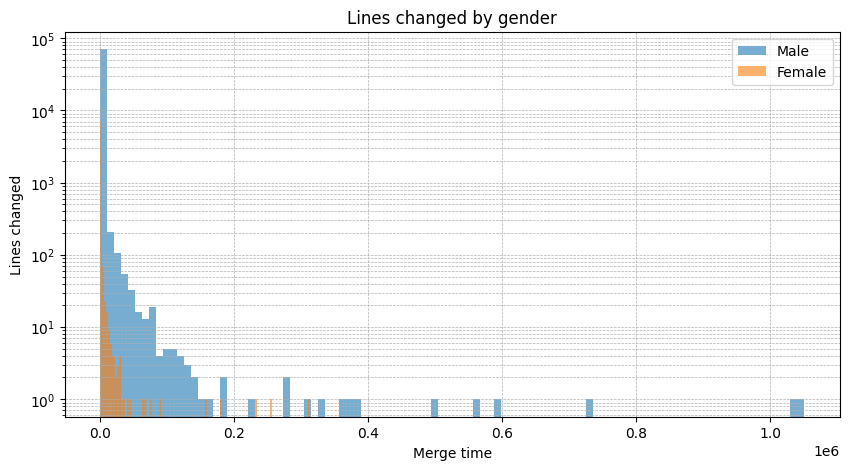

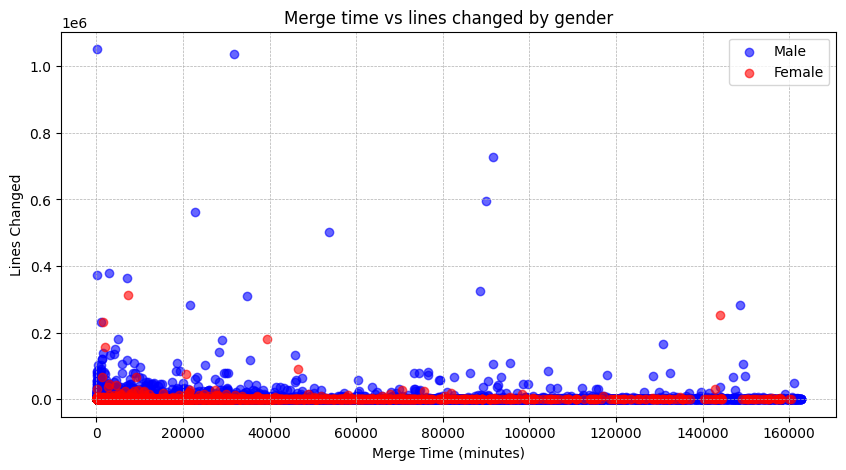

Shapiro-Wilk test for male contributors, number of lines changed: W = 0.016908259919442892, p = 1.894137581617461e-95
Shapiro-Wilk test for female contributors, number of lines changed: W = 0.047203805194954374, p = 1.0371903207700371e-94
Kruskal-Wallis H test, number of lines changed: H = 2.435345793196449, p = 0.11862773295975317
Mean lines changed for male contributors: 513.0820691790268
Mean lines changed for female contributors: 510.5871683811586
Median lines changed for male contributors: 22.0
Median lines changed for female contributors: 22.0
Standard deviation of lines changed for male contributors: 8700.687293974624
Standard deviation of lines changed for female contributors: 6561.475132325389
Maximum lines changed for male contributors: 1051094
Maximum lines changed for female contributors: 313140
Minimum lines changed for male contributors: 1
Minimum lines changed for female contributors: 1


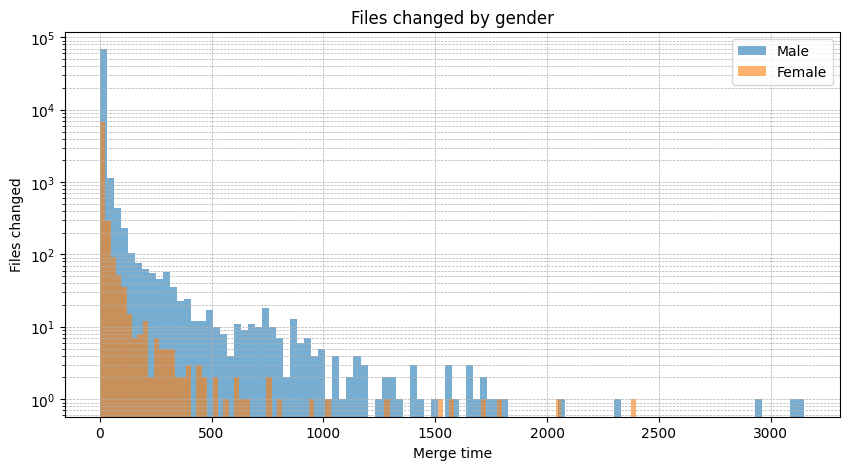

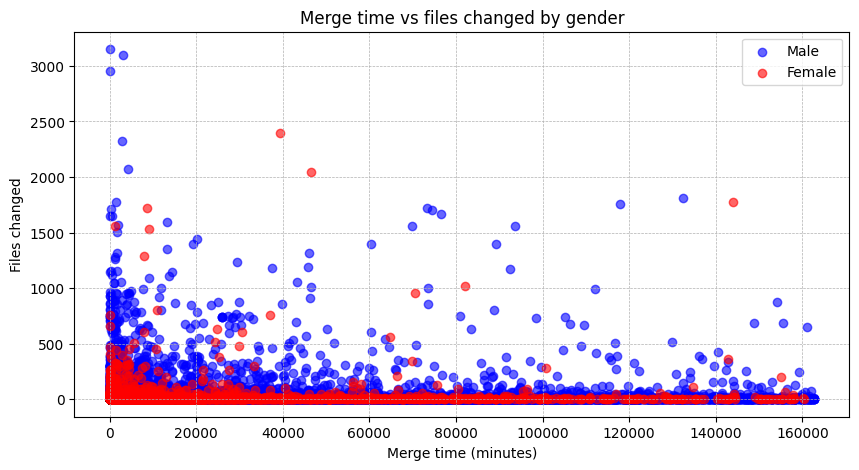

Shapiro-Wilk test for male contributors, number of files changed: W = 0.08117509663909861, p = 7.390894444546242e-94
Shapiro-Wilk test for female contributors, number of files changed: W = 0.11657154070836251, p = 6.124972069020772e-93
Kruskal-Wallis H test, number of files changed: H = 62.86609877088308, p = 2.2124780532479407e-15
Spearman correlation for male contributors, number files changed: rho = 0.2540951504905214, p = 0.0
Spearman correlation for male contributors, number files changed (log): rho = 0.2540951504905214, p = 0.0
Spearman correlation for female contributors, number files changed: rho = 0.16343959122052473, p = 2.1222602336381266e-45
Spearman correlation for female contributors, number files changed (log): rho = 0.16343959122052473, p = 2.1222602336381266e-45
Mean files changed for male contributors: 9.097956713855506
Mean files changed for female contributors: 11.842717920952897
Median files changed for male contributors: 2.0
Median files changed for female contrib

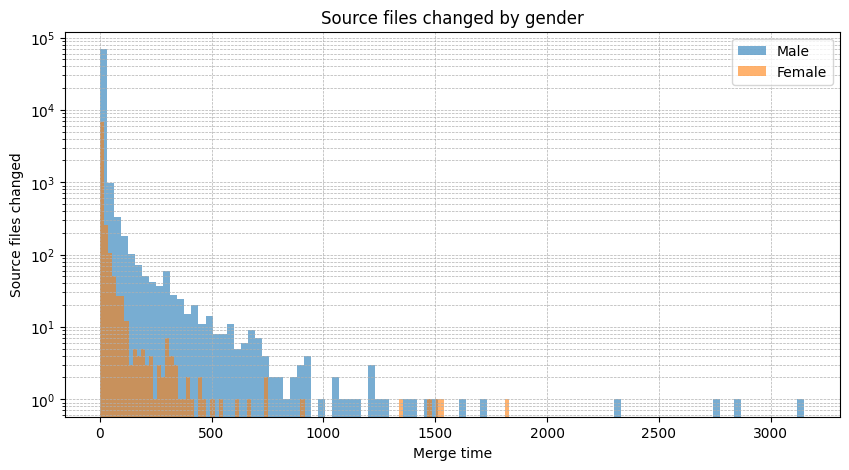

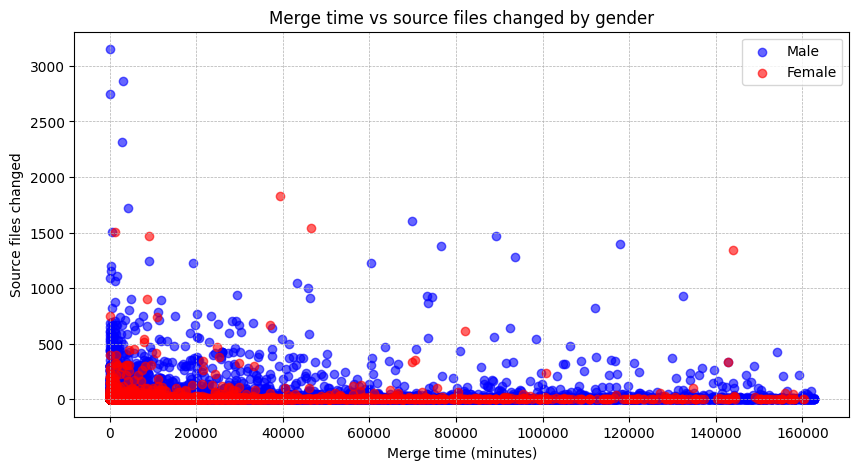

Shapiro-Wilk test for male contributors, number of source files changed: W = 0.07028750415211349, p = 3.912121297247981e-94
Shapiro-Wilk test for female contributors, number of source files changed: W = 0.10992540596339617, p = 4.094897614945807e-93
Kruskal-Wallis H test, number of source files changed: H = 78.43218805563933, p = 8.279207432309172e-19
Spearman correlation for male contributors, number source files changed: rho = 0.20993013681229294, p = 0.0
Spearman correlation for male contributors, number source files changed (log): rho = 0.20993013681229294, p = 0.0
Spearman correlation for female contributors, number source files changed: rho = 0.13371768588498373, p = 7.96852660577443e-31
Spearman correlation for female contributors, number source files changed (log): rho = 0.13371768588498373, p = 7.96852660577443e-31
Mean source files changed for male contributors: 6.955672511328136
Mean source files changed for female contributors: 9.162831618841365
Median source files changed 

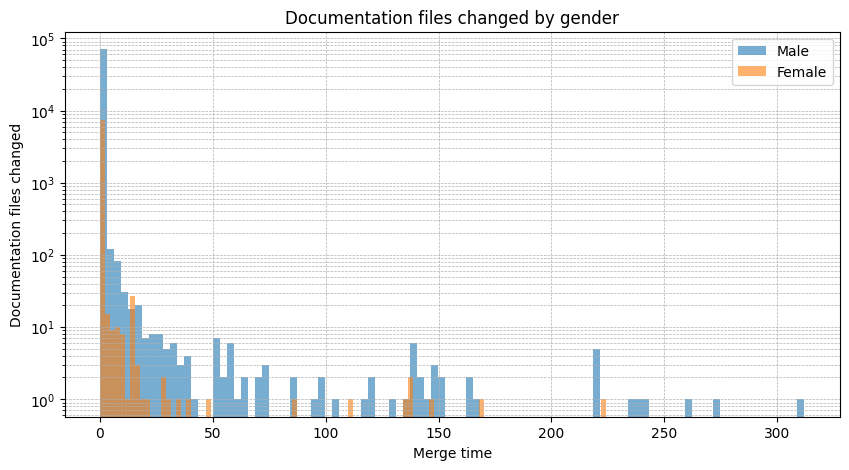

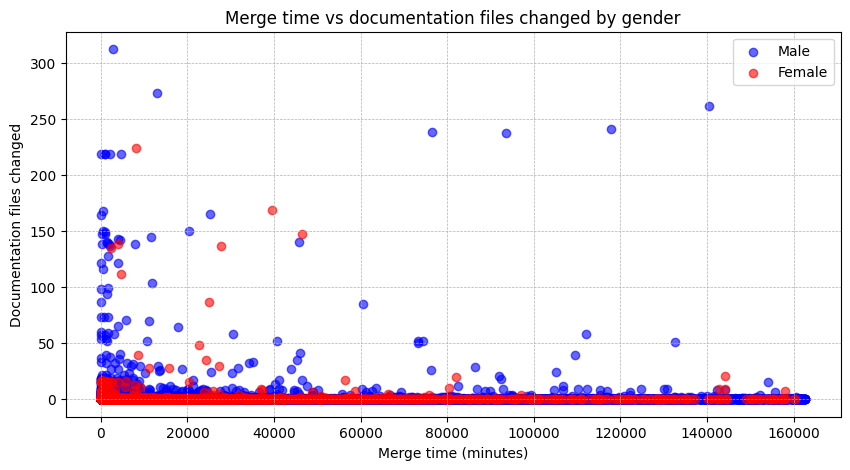

Shapiro-Wilk test for male contributors, number of documentation files changed: W = 0.024244116303688834, p = 2.8469373324820955e-95
Shapiro-Wilk test for female contributors, number of documentation files changed: W = 0.03166997714040776, p = 4.312244446350126e-95
Kruskal-Wallis H test, number of documentation files changed: H = 20.371746524068456, p = 6.376430787292094e-06
Spearman correlation for male contributors, number documentation files changed: rho = 0.04874924235124991, p = 1.179287180721047e-38
Spearman correlation for male contributors, number documentation files changed (log): rho = 0.04874924235124991, p = 1.179287180721047e-38
Spearman correlation for female contributors, number documentation files changed: rho = 0.029549641702253337, p = 0.01108463620062778
Spearman correlation for female contributors, number documentation files changed (log): rho = 0.029549641702253337, p = 0.01108463620062778
Mean documentation files changed for male contributors: 0.17878753764318484


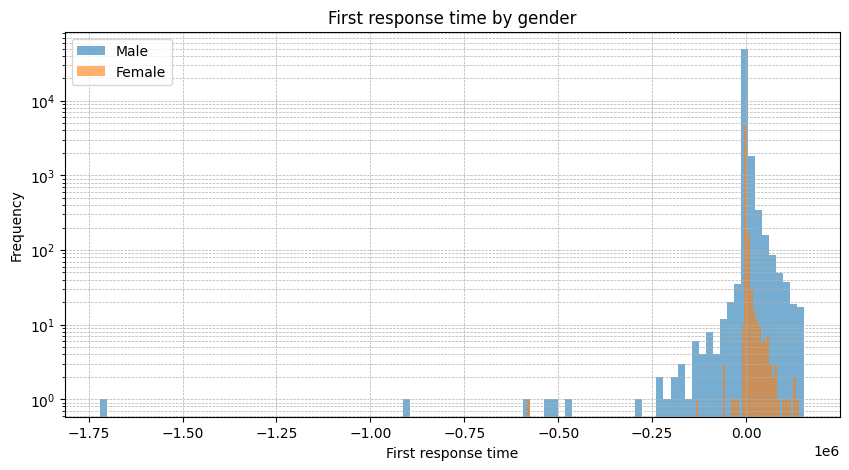

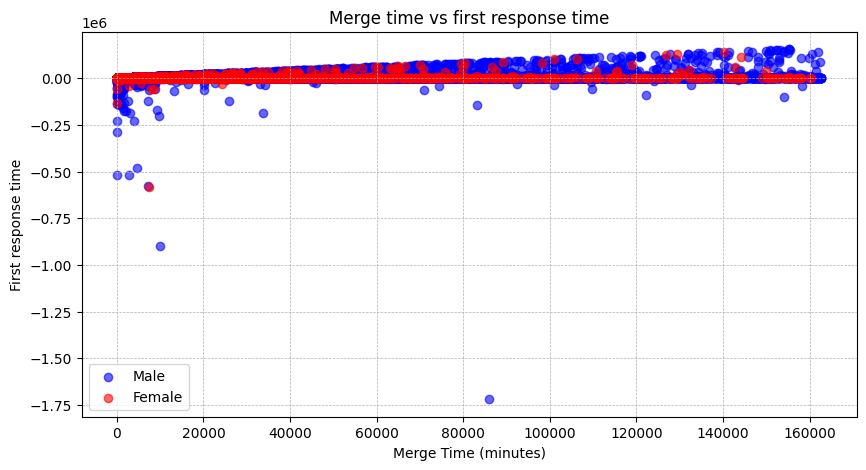

Shapiro-Wilk test for male contributors, first response time: W = 0.1139453627008461, p = 8.244165796491038e-85
Shapiro-Wilk test for female contributors, first response time: W = 0.06822533693827315, p = 5.988508213619631e-84
Kruskal-Wallis H test, number of documentation files changed: H = nan, p = nan
Spearman correlation for male contributors, first response time: rho = 0.11779640403672025, p = 2.4943135236929945e-159
Spearman correlation for male contributors, first response time (log): rho = 0.11779640403672025, p = 2.4943135236929945e-159
Spearman correlation for female contributors, first response time: rho = -0.003902770387314082, p = 0.7831134412500267
Spearman correlation for female contributors, first response time (log): rho = -0.003902770387314082, p = 0.7831134412500267
Mean first response time for male contributors: 1149.5373382267724
Mean first response time for female contributors: 839.4639340968455
Median first response time for male contributors: 12.0
Median first r

In [185]:
# see how many pull requests have been merged by contributor gender
gender = merged_data['contrib_gender'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(gender.index, gender.values, alpha=0.6, color=['blue', 'red'])
plt.xticks(gender.index, ['female', 'male'])
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Pull requests by gender')
plt.show()

male = merged_data[merged_data['contrib_gender'] == 'male']
female = merged_data[merged_data['contrib_gender'] == 'female']

# 1. merge time in minutes
plt.figure(figsize=(10, 5))
plt.hist(male['mergetime_minutes'], bins=100, alpha=0.6, label='male', log=True)
plt.hist(female['mergetime_minutes'], bins=100, alpha=0.6, label='female', log=True)
plt.xlabel('Merge time')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Merge time by gender')
plt.show()

sample_size = 5000
male_sample = male['mergetime_minutes'].sample(n=sample_size, random_state=1)
female_sample = female['mergetime_minutes'].sample(n=sample_size, random_state=1)

res_male = shapiro(male_sample)
res_female = shapiro(female_sample)
print('Shapiro-Wilk test for male contributors, merge time in minutes: W = {}, p = {}'.format(res_male.statistic, res_male.pvalue))
print('Shapiro-Wilk test for female contributors, merge time in minutes: W = {}, p = {}'.format(res_female.statistic, res_female.pvalue))

H, p = kruskal(male['mergetime_minutes'], female['mergetime_minutes'])
print('Kruskal-Wallis H test, merge time in minutes: H = {}, p = {}'.format(H, p))

print('Mean merge time for male contributors: {}'.format(male['mergetime_minutes'].mean()))
print('Mean merge time for female contributors: {}'.format(female['mergetime_minutes'].mean()))
print('Median merge time for male contributors: {}'.format(male['mergetime_minutes'].median()))
print('Median merge time for female contributors: {}'.format(female['mergetime_minutes'].median()))
print('Standard deviation of merge time for male contributors: {}'.format(male['mergetime_minutes'].std()))
print('Standard deviation of merge time for female contributors: {}'.format(female['mergetime_minutes'].std()))
print('Maximum merge time for male contributors: {}'.format(male['mergetime_minutes'].max()))
print('Maximum merge time for female contributors: {}'.format(female['mergetime_minutes'].max()))
print('Minimum merge time for male contributors: {}'.format(male['mergetime_minutes'].min()))
print('Minimum merge time for female contributors: {}'.format(female['mergetime_minutes'].min()))

# 2. lines changed
plt.figure(figsize=(10, 5))
plt.hist(male['src_churn'], bins=100, alpha=0.6, label='Male', log=True)
plt.hist(female['src_churn'], bins=100, alpha=0.6, label='Female', log=True)
plt.xlabel('Merge time')
plt.ylabel('Lines changed')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Lines changed by gender')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(male['mergetime_minutes'], male['src_churn'], alpha=0.6, color='blue', label='Male')
plt.scatter(female['mergetime_minutes'], female['src_churn'], alpha=0.6, color='red', label='Female')
plt.xlabel('Merge Time (minutes)')
plt.ylabel('Lines Changed')
plt.title('Merge time vs lines changed by gender')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

sample_size = 5000
male_sample = male['src_churn'].sample(n=sample_size, random_state=1)
female_sample = female['src_churn'].sample(n=sample_size, random_state=1)

res_male = shapiro(male_sample)
res_female = shapiro(female_sample)
print('Shapiro-Wilk test for male contributors, number of lines changed: W = {}, p = {}'.format(res_male.statistic, res_male.pvalue))
print('Shapiro-Wilk test for female contributors, number of lines changed: W = {}, p = {}'.format(res_female.statistic, res_female.pvalue))

H, p = kruskal(male['src_churn'], female['src_churn'])
print('Kruskal-Wallis H test, number of lines changed: H = {}, p = {}'.format(H, p))

print('Mean lines changed for male contributors: {}'.format(male['src_churn'].mean()))
print('Mean lines changed for female contributors: {}'.format(female['src_churn'].mean()))
print('Median lines changed for male contributors: {}'.format(male['src_churn'].median()))
print('Median lines changed for female contributors: {}'.format(female['src_churn'].median()))
print('Standard deviation of lines changed for male contributors: {}'.format(male['src_churn'].std()))
print('Standard deviation of lines changed for female contributors: {}'.format(female['src_churn'].std()))
print('Maximum lines changed for male contributors: {}'.format(male['src_churn'].max()))
print('Maximum lines changed for female contributors: {}'.format(female['src_churn'].max()))
print('Minimum lines changed for male contributors: {}'.format(male['src_churn'].min()))
print('Minimum lines changed for female contributors: {}'.format(female['src_churn'].min()))

# 3. files changed
plt.figure(figsize=(10, 5))
plt.hist(male['files_changed'], bins=100, alpha=0.6, label='Male', log=True)
plt.hist(female['files_changed'], bins=100, alpha=0.6, label='Female', log=True)
plt.xlabel('Merge time')
plt.ylabel('Files changed')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Files changed by gender')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(male['mergetime_minutes'], male['files_changed'], alpha=0.6, color='blue', label='Male')
plt.scatter(female['mergetime_minutes'], female['files_changed'], alpha=0.6, color='red', label='Female')
plt.xlabel('Merge time (minutes)')
plt.ylabel('Files changed')
plt.title('Merge time vs files changed by gender')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

sample_size = 5000
male_sample = male['files_changed'].sample(n=sample_size, random_state=1)
female_sample = female['files_changed'].sample(n=sample_size, random_state=1)

res_male = shapiro(male_sample)
res_female = shapiro(female_sample)
print('Shapiro-Wilk test for male contributors, number of files changed: W = {}, p = {}'.format(res_male.statistic, res_male.pvalue))
print('Shapiro-Wilk test for female contributors, number of files changed: W = {}, p = {}'.format(res_female.statistic, res_female.pvalue))

H, p = kruskal(male['files_changed'], female['files_changed'])
print('Kruskal-Wallis H test, number of files changed: H = {}, p = {}'.format(H, p))

spearman_male = spearmanr(male['mergetime_minutes'], male['files_changed'])
print('Spearman correlation for male contributors, number files changed: rho = {}, p = {}'.format(spearman_male.statistic, spearman_male.pvalue))
spearman_male_log = spearmanr(male['log_mergetime_minutes'], male['files_changed'])
print('Spearman correlation for male contributors, number files changed (log): rho = {}, p = {}'.format(spearman_male_log.statistic, spearman_male_log.pvalue))

spearman_female = spearmanr(female['mergetime_minutes'], female['files_changed'])
print('Spearman correlation for female contributors, number files changed: rho = {}, p = {}'.format(spearman_female.statistic, spearman_female.pvalue))
spearman_female_log = spearmanr(female['log_mergetime_minutes'], female['files_changed'])
print('Spearman correlation for female contributors, number files changed (log): rho = {}, p = {}'.format(spearman_female_log.statistic, spearman_female_log.pvalue))

print('Mean files changed for male contributors: {}'.format(male['files_changed'].mean()))
print('Mean files changed for female contributors: {}'.format(female['files_changed'].mean()))
print('Median files changed for male contributors: {}'.format(male['files_changed'].median()))
print('Median files changed for female contributors: {}'.format(female['files_changed'].median()))
print('Standard deviation of files changed for male contributors: {}'.format(male['files_changed'].std()))
print('Standard deviation of files changed for female contributors: {}'.format(female['files_changed'].std()))
print('Maximum files changed for male contributors: {}'.format(male['files_changed'].max()))
print('Maximum files changed for female contributors: {}'.format(female['files_changed'].max()))
print('Minimum files changed for male contributors: {}'.format(male['files_changed'].min()))
print('Minimum files changed for female contributors: {}'.format(female['files_changed'].min()))

# 4. source files changed
plt.figure(figsize=(10, 5))
plt.hist(male['src_files'], bins=100, alpha=0.6, label='Male', log=True)
plt.hist(female['src_files'], bins=100, alpha=0.6, label='Female', log=True)
plt.xlabel('Merge time')
plt.ylabel('Source files changed')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Source files changed by gender')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(male['mergetime_minutes'], male['src_files'], alpha=0.6, color='blue', label='Male')
plt.scatter(female['mergetime_minutes'], female['src_files'], alpha=0.6, color='red', label='Female')
plt.xlabel('Merge time (minutes)')
plt.ylabel('Source files changed')
plt.title('Merge time vs source files changed by gender')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

sample_size = 5000
male_sample = male['src_files'].sample(n=sample_size, random_state=1)
female_sample = female['src_files'].sample(n=sample_size, random_state=1)

res_male = shapiro(male_sample)
res_female = shapiro(female_sample)
print('Shapiro-Wilk test for male contributors, number of source files changed: W = {}, p = {}'.format(res_male.statistic, res_male.pvalue))
print('Shapiro-Wilk test for female contributors, number of source files changed: W = {}, p = {}'.format(res_female.statistic, res_female.pvalue))

H, p = kruskal(male['src_files'], female['src_files'])
print('Kruskal-Wallis H test, number of source files changed: H = {}, p = {}'.format(H, p))

spearman_male = spearmanr(male['mergetime_minutes'], male['src_files'])
print('Spearman correlation for male contributors, number source files changed: rho = {}, p = {}'.format(spearman_male.statistic, spearman_male.pvalue))
spearman_male_log = spearmanr(male['log_mergetime_minutes'], male['src_files'])
print('Spearman correlation for male contributors, number source files changed (log): rho = {}, p = {}'.format(spearman_male_log.statistic, spearman_male_log.pvalue))

spearman_female = spearmanr(female['mergetime_minutes'], female['src_files'])
print('Spearman correlation for female contributors, number source files changed: rho = {}, p = {}'.format(spearman_female.statistic, spearman_female.pvalue))
spearman_female_log = spearmanr(female['log_mergetime_minutes'], female['src_files'])
print('Spearman correlation for female contributors, number source files changed (log): rho = {}, p = {}'.format(spearman_female_log.statistic, spearman_female_log.pvalue))

print('Mean source files changed for male contributors: {}'.format(male['src_files'].mean()))
print('Mean source files changed for female contributors: {}'.format(female['src_files'].mean()))
print('Median source files changed for male contributors: {}'.format(male['src_files'].median()))
print('Median source files changed for female contributors: {}'.format(female['src_files'].median()))
print('Standard deviation of source files changed for male contributors: {}'.format(male['src_files'].std()))
print('Standard deviation of source files changed for female contributors: {}'.format(female['src_files'].std()))
print('Maximum source files changed for male contributors: {}'.format(male['src_files'].max()))
print('Maximum source files changed for female contributors: {}'.format(female['src_files'].max()))
print('Minimum source files changed for male contributors: {}'.format(male['src_files'].min()))
print('Minimum source files changed for female contributors: {}'.format(female['src_files'].min()))

# 5. documentation files changed
plt.figure(figsize=(10, 5))
plt.hist(male['doc_files'], bins=100, alpha=0.6, label='Male', log=True)
plt.hist(female['doc_files'], bins=100, alpha=0.6, label='Female', log=True)
plt.xlabel('Merge time')
plt.ylabel('Documentation files changed')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Documentation files changed by gender')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(male['mergetime_minutes'], male['doc_files'], alpha=0.6, color='blue', label='Male')
plt.scatter(female['mergetime_minutes'], female['doc_files'], alpha=0.6, color='red', label='Female')
plt.xlabel('Merge time (minutes)')
plt.ylabel('Documentation files changed')
plt.title('Merge time vs documentation files changed by gender')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

sample_size = 5000
male_sample = male['doc_files'].sample(n=sample_size, random_state=1)
female_sample = female['doc_files'].sample(n=sample_size, random_state=1)

res_male = shapiro(male_sample)
res_female = shapiro(female_sample)
print('Shapiro-Wilk test for male contributors, number of documentation files changed: W = {}, p = {}'.format(res_male.statistic, res_male.pvalue))
print('Shapiro-Wilk test for female contributors, number of documentation files changed: W = {}, p = {}'.format(res_female.statistic, res_female.pvalue))

H, p = kruskal(male['doc_files'], female['doc_files'])
print('Kruskal-Wallis H test, number of documentation files changed: H = {}, p = {}'.format(H, p))

spearman_male = spearmanr(male['mergetime_minutes'], male['doc_files'])
print('Spearman correlation for male contributors, number documentation files changed: rho = {}, p = {}'.format(spearman_male.statistic, spearman_male.pvalue))
spearman_male_log = spearmanr(male['log_mergetime_minutes'], male['doc_files'])
print('Spearman correlation for male contributors, number documentation files changed (log): rho = {}, p = {}'.format(spearman_male_log.statistic, spearman_male_log.pvalue))

spearman_female = spearmanr(female['mergetime_minutes'], female['doc_files'])
print('Spearman correlation for female contributors, number documentation files changed: rho = {}, p = {}'.format(spearman_female.statistic, spearman_female.pvalue))
spearman_female_log = spearmanr(female['log_mergetime_minutes'], female['doc_files'])
print('Spearman correlation for female contributors, number documentation files changed (log): rho = {}, p = {}'.format(spearman_female_log.statistic, spearman_female_log.pvalue))

print('Mean documentation files changed for male contributors: {}'.format(male['doc_files'].mean()))
print('Mean documentation files changed for female contributors: {}'.format(female['doc_files'].mean()))
print('Median documentation files changed for male contributors: {}'.format(male['doc_files'].median()))
print('Median documentation files changed for female contributors: {}'.format(female['doc_files'].median()))
print('Standard deviation of documentation files changed for male contributors: {}'.format(male['doc_files'].std()))
print('Standard deviation of documentation files changed for female contributors: {}'.format(female['doc_files'].std()))
print('Maximum documentation files changed for male contributors: {}'.format(male['doc_files'].max()))
print('Maximum documentation files changed for female contributors: {}'.format(female['doc_files'].max()))
print('Minimum documentation files changed for male contributors: {}'.format(male['doc_files'].min()))
print('Minimum documentation files changed for female contributors: {}'.format(female['doc_files'].min()))

# 6. first response time
plt.figure(figsize=(10, 5))
plt.hist(male['first_response_time'], bins=100, alpha=0.6, label='Male', log=True)
plt.hist(female['first_response_time'], bins=100, alpha=0.6, label='Female', log=True)
plt.xlabel('First response time')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('First response time by gender')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(male['mergetime_minutes'], male['first_response_time'], alpha=0.6, color='blue', label='Male')
plt.scatter(female['mergetime_minutes'], female['first_response_time'], alpha=0.6, color='red', label='Female')
plt.xlabel('Merge Time (minutes)')
plt.ylabel('First response time')
plt.title('Merge time vs first response time')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

sample_size = 5000
male_sample = male['first_response_time'].sample(n=sample_size, random_state=1)
female_sample = female['first_response_time'].sample(n=sample_size, random_state=1)

res_male = shapiro(male_sample.dropna())
res_female = shapiro(female_sample.dropna())
print('Shapiro-Wilk test for male contributors, first response time: W = {}, p = {}'.format(res_male.statistic, res_male.pvalue))
print('Shapiro-Wilk test for female contributors, first response time: W = {}, p = {}'.format(res_female.statistic, res_female.pvalue))

H, p = kruskal(male['first_response_time'], female['first_response_time'])
print('Kruskal-Wallis H test, number of documentation files changed: H = {}, p = {}'.format(H, p))

spearman_male = spearmanr(male['mergetime_minutes'], male['first_response_time'], nan_policy='omit')
print('Spearman correlation for male contributors, first response time: rho = {}, p = {}'.format(spearman_male.statistic, spearman_male.pvalue))
spearman_male_log = spearmanr(male['log_mergetime_minutes'], male['first_response_time'], nan_policy='omit')
print('Spearman correlation for male contributors, first response time (log): rho = {}, p = {}'.format(spearman_male_log.statistic, spearman_male_log.pvalue))

spearman_female = spearmanr(female['mergetime_minutes'], female['first_response_time'], nan_policy='omit')
print('Spearman correlation for female contributors, first response time: rho = {}, p = {}'.format(spearman_female.statistic, spearman_female.pvalue))
spearman_female_log = spearmanr(female['log_mergetime_minutes'], female['first_response_time'], nan_policy='omit')
print('Spearman correlation for female contributors, first response time (log): rho = {}, p = {}'.format(spearman_female_log.statistic, spearman_female_log.pvalue))

print('Mean first response time for male contributors: {}'.format(male['first_response_time'].mean()))
print('Mean first response time for female contributors: {}'.format(female['first_response_time'].mean()))
print('Median first response time for male contributors: {}'.format(male['first_response_time'].median()))
print('Median first response time for female contributors: {}'.format(female['first_response_time'].median()))
print('Standard deviation of first response time for male contributors: {}'.format(male['first_response_time'].std()))
print('Standard deviation of first response time for female contributors: {}'.format(female['first_response_time'].std()))
print('Maximum first response time for male contributors: {}'.format(male['first_response_time'].max()))
print('Maximum first response time for female contributors: {}'.format(female['first_response_time'].max()))
print('Minimum first response time for male contributors: {}'.format(male['first_response_time'].min()))
print('Minimum first response time for female contributors: {}'.format(female['first_response_time'].min()))

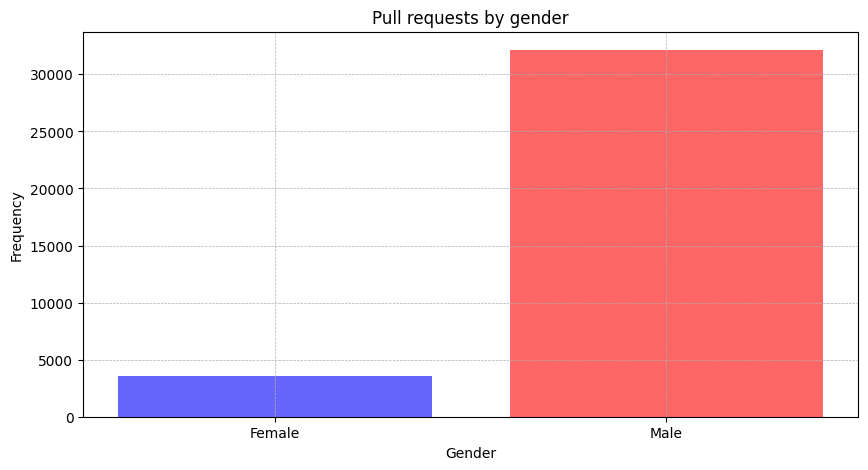

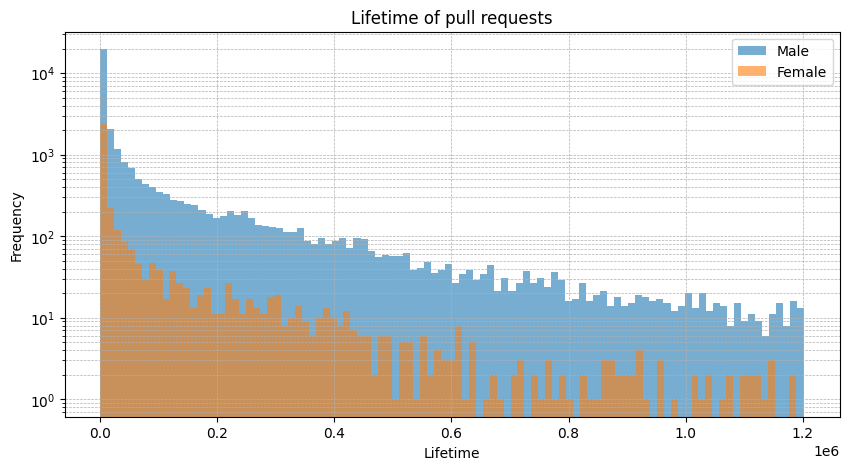

Shapiro-Wilk test for male contributors, lifetime: W = 0.5065361614993478, p = 1.6313607635049995e-71
Shapiro-Wilk test for female contributors, lifetime: W = 0.46297732459464014, p = 3.13651514781949e-73
Kruskal-Wallis H test, lifetime: H = 26.68736451212559, p = 2.391804919978881e-07
Mean lifetime for male contributors: 79895.19261057678
Mean lifetime for female contributors: 64461.451559020046
Median lifetime for male contributors: 5166.0
Median lifetime for female contributors: 4228.0
Standard deviation of lifetime for male contributors: 177328.30728168157
Standard deviation of lifetime for female contributors: 158444.86650986792
Maximum lifetime for male contributors: 1202600
Maximum lifetime for female contributors: 1188090
Minimum lifetime for male contributors: 7
Minimum lifetime for female contributors: 7


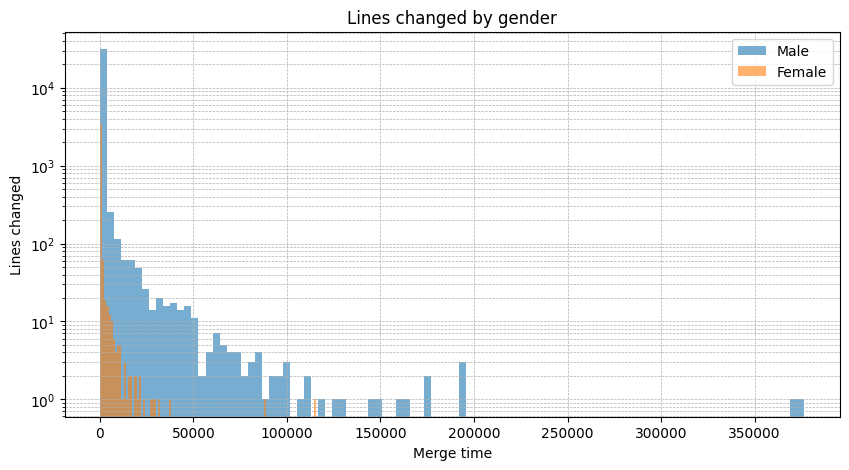

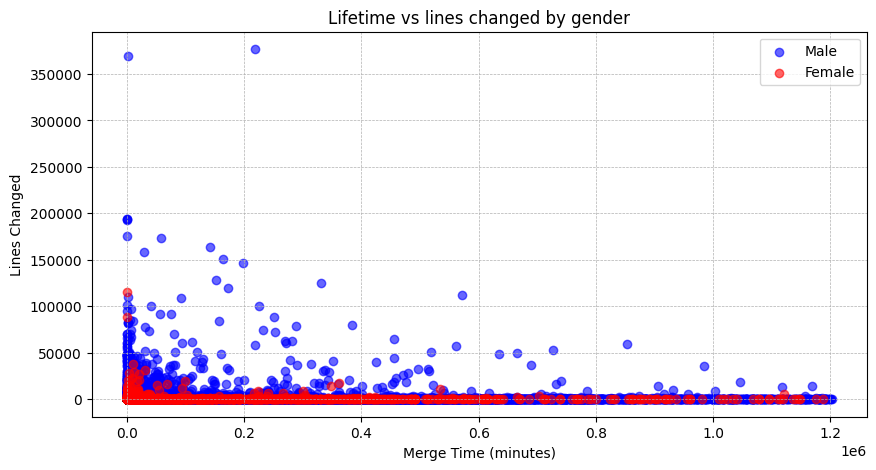

Shapiro-Wilk test for male contributors, number of lines changed: W = 0.09039077201495349, p = 2.1683230647931897e-84
Shapiro-Wilk test for female contributors, number of lines changed: W = 0.08905778710248946, p = 2.0136489043371808e-84
Kruskal-Wallis H test, number of lines changed: H = 18.114837622562924, p = 2.079744924489085e-05
Spearman correlation for male contributors, number of lines changed: rho = 0.23296007917530254, p = 0.0
Spearman correlation for male contributors, number of lines changed (log): rho = 0.23296007917530254, p = 0.0
Spearman correlation for female contributors, number of lines changed: rho = 0.23980513350273255, p = 3.734271124366558e-48
Spearman correlation for female contributors, number of  lines changed (log): rho = 0.23980513350273255, p = 3.734271124366558e-48
Mean lines changed for male contributors: 636.9386497338687
Mean lines changed for female contributors: 381.53062360801783
Median lines changed for male contributors: 18.0
Median lines changed fo

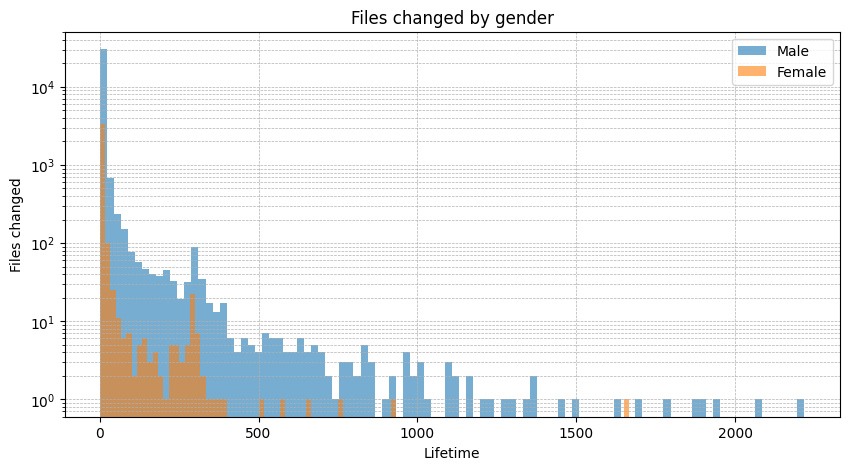

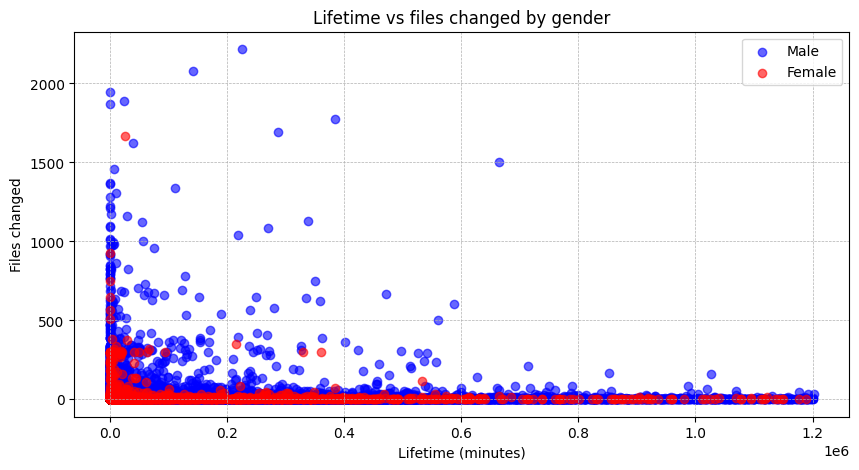

Shapiro-Wilk test for male contributors, number of files changed: W = 0.11255401631681639, p = 7.526406134709163e-84
Shapiro-Wilk test for female contributors, number of files changed: W = 0.15843931811589274, p = 1.080846839205139e-82
Kruskal-Wallis H test, number of files changed: H = 13.81310911177153, p = 0.00020192243519589402
Spearman correlation for male contributors, number of files changed: rho = 0.19480501157648084, p = 3.006309820081625e-272
Spearman correlation for male contributors, number of files changed (log): rho = 0.19480501157648084, p = 3.006309820081625e-272
Spearman correlation for female contributors, number of files changed: rho = 0.2385576653823298, p = 1.1691570711632647e-47
Spearman correlation for female contributors, number of files changed (log): rho = 0.2385576653823298, p = 1.1691570711632647e-47
Mean files changed for male contributors: 11.32368412861456
Mean files changed for female contributors: 10.581570155902005
Median files changed for male contrib

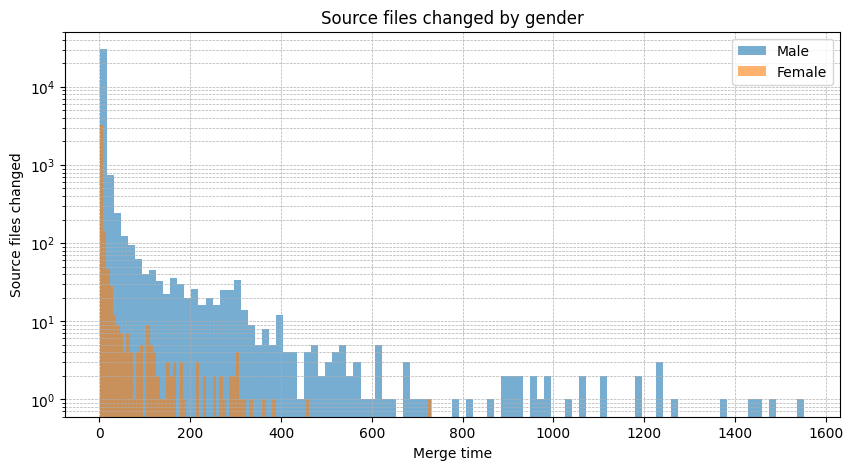

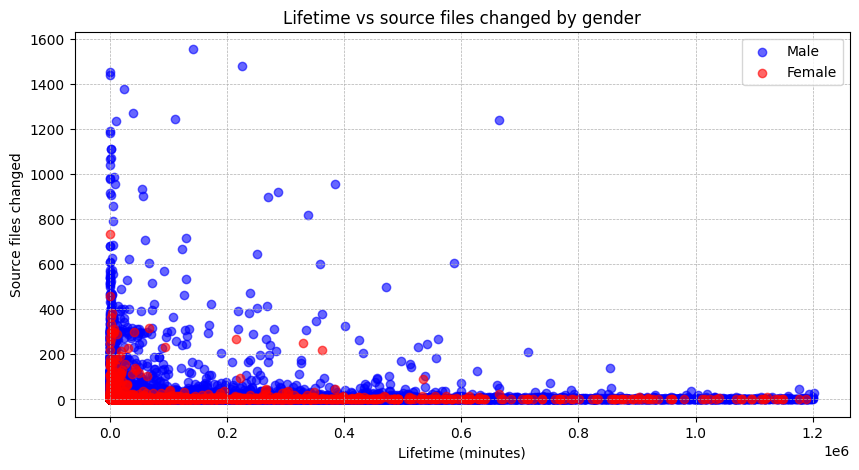

Shapiro-Wilk test for male contributors, number of source files changed: W = 0.1057737895644556, p = 5.128816265723189e-84
Shapiro-Wilk test for female contributors, number of source files changed: W = 0.17492033282815156, p = 2.902437725847242e-82
Kruskal-Wallis H test, number of source files changed: H = 7.624622598913069, p = 0.005757671702968108
Spearman correlation for male contributors, number source files changed: rho = 0.1795947908991507, p = 4.830358417010966e-231
Spearman correlation for male contributors, number source files changed (log): rho = 0.1795947908991507, p = 4.830358417010966e-231
Spearman correlation for female contributors, number source of files changed: rho = 0.2098496755918753, p = 4.91706177045103e-37
Spearman correlation for female contributors, number source of files changed (log): rho = 0.2098496755918753, p = 4.91706177045103e-37
Mean source files changed for male contributors: 8.51405359977589
Mean source files changed for female contributors: 6.9053452

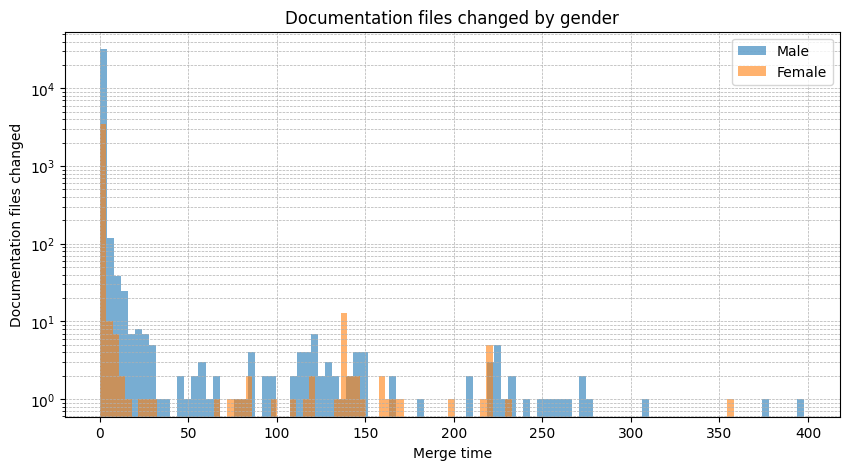

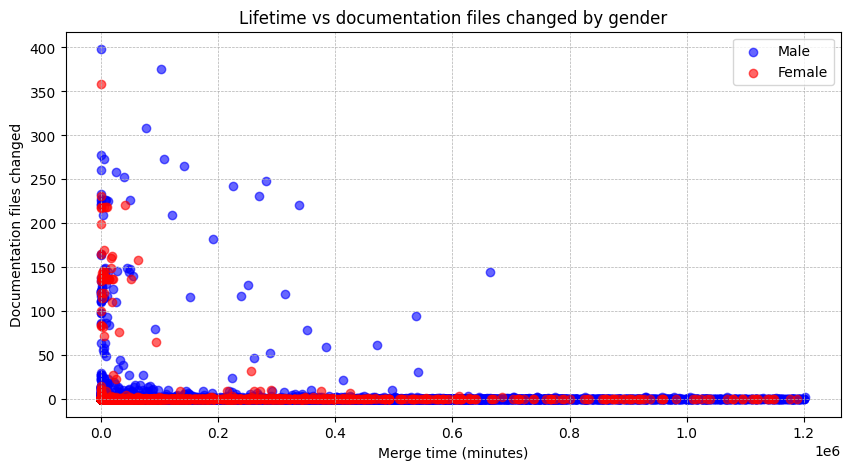

Shapiro-Wilk test for male contributors, number of documentation files changed: W = 0.03956440692007368, p = 1.3758584237038122e-85
Shapiro-Wilk test for female contributors, number of documentation files changed: W = 0.08835543937049484, p = 1.9367140798825552e-84
Kruskal-Wallis H test, number of documentation files changed: H = 0.8054269665497512, p = 0.36947573279448054
Spearman correlation for male contributors, number of documentation files changed: rho = 0.04074676773865034, p = 2.7479666763774873e-13
Spearman correlation for male contributors, number of documentation files changed (log): rho = 0.04074676773865034, p = 2.7479666763774873e-13
Spearman correlation for female contributors, number of documentation files changed: rho = 0.0782704536125257, p = 2.6455396126460126e-06
Spearman correlation for female contributors, number of documentation files changed (log): rho = 0.0782704536125257, p = 2.6455396126460126e-06
Mean documentation files changed for male contributors: 0.5002

In [186]:
gender = closed_data['contrib_gender'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(gender.index, gender.values, alpha=0.6, color=['blue', 'red'])
plt.xticks(gender.index, ['Female', 'Male'])
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Pull requests by gender')
plt.show()

# 1. lifetime
male = closed_data[closed_data['contrib_gender'] == 'male']
female = closed_data[closed_data['contrib_gender'] == 'female']

plt.figure(figsize=(10, 5))
plt.hist(male['lifetime_minutes'], bins=100, alpha=0.6, label='Male', log=True)
plt.hist(female['lifetime_minutes'], bins=100, alpha=0.6, label='Female', log=True)
plt.xlabel('Lifetime')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Lifetime of pull requests')
plt.show()

sample_size = 3500
male_sample = male['lifetime_minutes'].sample(n=sample_size, random_state=1)
female_sample = female['lifetime_minutes'].sample(n=sample_size, random_state=1)

res_male = shapiro(male_sample)
res_female = shapiro(female_sample)
print('Shapiro-Wilk test for male contributors, lifetime: W = {}, p = {}'.format(res_male.statistic, res_male.pvalue))
print('Shapiro-Wilk test for female contributors, lifetime: W = {}, p = {}'.format(res_female.statistic, res_female.pvalue))

H, p = kruskal(male['lifetime_minutes'], female['lifetime_minutes'])
print('Kruskal-Wallis H test, lifetime: H = {}, p = {}'.format(H, p))

print('Mean lifetime for male contributors: {}'.format(male['lifetime_minutes'].mean()))
print('Mean lifetime for female contributors: {}'.format(female['lifetime_minutes'].mean()))
print('Median lifetime for male contributors: {}'.format(male['lifetime_minutes'].median()))
print('Median lifetime for female contributors: {}'.format(female['lifetime_minutes'].median()))
print('Standard deviation of lifetime for male contributors: {}'.format(male['lifetime_minutes'].std()))
print('Standard deviation of lifetime for female contributors: {}'.format(female['lifetime_minutes'].std()))
print('Maximum lifetime for male contributors: {}'.format(male['lifetime_minutes'].max()))
print('Maximum lifetime for female contributors: {}'.format(female['lifetime_minutes'].max()))
print('Minimum lifetime for male contributors: {}'.format(male['lifetime_minutes'].min()))
print('Minimum lifetime for female contributors: {}'.format(female['lifetime_minutes'].min()))

# 2. lines changed
plt.figure(figsize=(10, 5))
plt.hist(male['src_churn'], bins=100, alpha=0.6, label='Male', log=True)
plt.hist(female['src_churn'], bins=100, alpha=0.6, label='Female', log=True)
plt.xlabel('Merge time')
plt.ylabel('Lines changed')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Lines changed by gender')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(male['lifetime_minutes'], male['src_churn'], alpha=0.6, color='blue', label='Male')
plt.scatter(female['lifetime_minutes'], female['src_churn'], alpha=0.6, color='red', label='Female')
plt.xlabel('Merge Time (minutes)')
plt.ylabel('Lines Changed')
plt.title('Lifetime vs lines changed by gender')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

sample_size = 3500
male_sample = male['src_churn'].sample(n=sample_size, random_state=1)
female_sample = female['src_churn'].sample(n=sample_size, random_state=1)

res_male = shapiro(male_sample)
res_female = shapiro(female_sample)
print('Shapiro-Wilk test for male contributors, number of lines changed: W = {}, p = {}'.format(res_male.statistic, res_male.pvalue))
print('Shapiro-Wilk test for female contributors, number of lines changed: W = {}, p = {}'.format(res_female.statistic, res_female.pvalue))

H, p = kruskal(male['src_churn'], female['src_churn'])
print('Kruskal-Wallis H test, number of lines changed: H = {}, p = {}'.format(H, p))

spearman_male = spearmanr(male['lifetime_minutes'], male['src_churn'])
print('Spearman correlation for male contributors, number of lines changed: rho = {}, p = {}'.format(spearman_male.statistic, spearman_male.pvalue))
spearman_male_log = spearmanr(male['log_lifetime_minutes'], male['src_churn'])
print('Spearman correlation for male contributors, number of lines changed (log): rho = {}, p = {}'.format(spearman_male_log.statistic, spearman_male_log.pvalue))

spearman_female = spearmanr(female['lifetime_minutes'], female['src_churn'])
print('Spearman correlation for female contributors, number of lines changed: rho = {}, p = {}'.format(spearman_female.statistic, spearman_female.pvalue))
spearman_female_log = spearmanr(female['log_lifetime_minutes'], female['src_churn'])
print('Spearman correlation for female contributors, number of  lines changed (log): rho = {}, p = {}'.format(spearman_female_log.statistic, spearman_female_log.pvalue))


print('Mean lines changed for male contributors: {}'.format(male['src_churn'].mean()))
print('Mean lines changed for female contributors: {}'.format(female['src_churn'].mean()))
print('Median lines changed for male contributors: {}'.format(male['src_churn'].median()))
print('Median lines changed for female contributors: {}'.format(female['src_churn'].median()))
print('Standard deviation of lines changed for male contributors: {}'.format(male['src_churn'].std()))
print('Standard deviation of lines changed for female contributors: {}'.format(female['src_churn'].std()))
print('Maximum lines changed for male contributors: {}'.format(male['src_churn'].max()))
print('Maximum lines changed for female contributors: {}'.format(female['src_churn'].max()))
print('Minimum lines changed for male contributors: {}'.format(male['src_churn'].min()))
print('Minimum lines changed for female contributors: {}'.format(female['src_churn'].min()))

# 3. files changed
plt.figure(figsize=(10, 5))
plt.hist(male['files_changed'], bins=100, alpha=0.6, label='Male', log=True)
plt.hist(female['files_changed'], bins=100, alpha=0.6, label='Female', log=True)
plt.xlabel('Lifetime')
plt.ylabel('Files changed')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Files changed by gender')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(male['lifetime_minutes'], male['files_changed'], alpha=0.6, color='blue', label='Male')
plt.scatter(female['lifetime_minutes'], female['files_changed'], alpha=0.6, color='red', label='Female')
plt.xlabel('Lifetime (minutes)')
plt.ylabel('Files changed')
plt.title('Lifetime vs files changed by gender')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

sample_size = 3500
male_sample = male['files_changed'].sample(n=sample_size, random_state=1)
female_sample = female['files_changed'].sample(n=sample_size, random_state=1)

res_male = shapiro(male_sample)
res_female = shapiro(female_sample)
print('Shapiro-Wilk test for male contributors, number of files changed: W = {}, p = {}'.format(res_male.statistic, res_male.pvalue))
print('Shapiro-Wilk test for female contributors, number of files changed: W = {}, p = {}'.format(res_female.statistic, res_female.pvalue))

H, p = kruskal(male['files_changed'], female['files_changed'])
print('Kruskal-Wallis H test, number of files changed: H = {}, p = {}'.format(H, p))

spearman_male = spearmanr(male['lifetime_minutes'], male['files_changed'])
print('Spearman correlation for male contributors, number of files changed: rho = {}, p = {}'.format(spearman_male.statistic, spearman_male.pvalue))
spearman_male_log = spearmanr(male['log_lifetime_minutes'], male['files_changed'])
print('Spearman correlation for male contributors, number of files changed (log): rho = {}, p = {}'.format(spearman_male_log.statistic, spearman_male_log.pvalue))

spearman_female = spearmanr(female['lifetime_minutes'], female['files_changed'])
print('Spearman correlation for female contributors, number of files changed: rho = {}, p = {}'.format(spearman_female.statistic, spearman_female.pvalue))
spearman_female_log = spearmanr(female['log_lifetime_minutes'], female['files_changed'])
print('Spearman correlation for female contributors, number of files changed (log): rho = {}, p = {}'.format(spearman_female_log.statistic, spearman_female_log.pvalue))

print('Mean files changed for male contributors: {}'.format(male['files_changed'].mean()))
print('Mean files changed for female contributors: {}'.format(female['files_changed'].mean()))
print('Median files changed for male contributors: {}'.format(male['files_changed'].median()))
print('Median files changed for female contributors: {}'.format(female['files_changed'].median()))
print('Standard deviation of files changed for male contributors: {}'.format(male['files_changed'].std()))
print('Standard deviation of files changed for female contributors: {}'.format(female['files_changed'].std()))
print('Maximum files changed for male contributors: {}'.format(male['files_changed'].max()))
print('Maximum files changed for female contributors: {}'.format(female['files_changed'].max()))
print('Minimum files changed for male contributors: {}'.format(male['files_changed'].min()))
print('Minimum files changed for female contributors: {}'.format(female['files_changed'].min()))

# 4. source files changed
plt.figure(figsize=(10, 5))
plt.hist(male['src_files'], bins=100, alpha=0.6, label='Male', log=True)
plt.hist(female['src_files'], bins=100, alpha=0.6, label='Female', log=True)
plt.xlabel('Merge time')
plt.ylabel('Source files changed')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Source files changed by gender')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(male['lifetime_minutes'], male['src_files'], alpha=0.6, color='blue', label='Male')
plt.scatter(female['lifetime_minutes'], female['src_files'], alpha=0.6, color='red', label='Female')
plt.xlabel('Lifetime (minutes)')
plt.ylabel('Source files changed')
plt.title('Lifetime vs source files changed by gender')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

sample_size = 3500
male_sample = male['src_files'].sample(n=sample_size, random_state=1)
female_sample = female['src_files'].sample(n=sample_size, random_state=1)

res_male = shapiro(male_sample)
res_female = shapiro(female_sample)
print('Shapiro-Wilk test for male contributors, number of source files changed: W = {}, p = {}'.format(res_male.statistic, res_male.pvalue))
print('Shapiro-Wilk test for female contributors, number of source files changed: W = {}, p = {}'.format(res_female.statistic, res_female.pvalue))

H, p = kruskal(male['src_files'], female['src_files'])
print('Kruskal-Wallis H test, number of source files changed: H = {}, p = {}'.format(H, p))

spearman_male = spearmanr(male['lifetime_minutes'], male['src_files'])
print('Spearman correlation for male contributors, number source files changed: rho = {}, p = {}'.format(spearman_male.statistic, spearman_male.pvalue))
spearman_male_log = spearmanr(male['log_lifetime_minutes'], male['src_files'])
print('Spearman correlation for male contributors, number source files changed (log): rho = {}, p = {}'.format(spearman_male_log.statistic, spearman_male_log.pvalue))

spearman_female = spearmanr(female['lifetime_minutes'], female['src_files'])
print('Spearman correlation for female contributors, number source of files changed: rho = {}, p = {}'.format(spearman_female.statistic, spearman_female.pvalue))
spearman_female_log = spearmanr(female['log_lifetime_minutes'], female['src_files'])
print('Spearman correlation for female contributors, number source of files changed (log): rho = {}, p = {}'.format(spearman_female_log.statistic, spearman_female_log.pvalue))

print('Mean source files changed for male contributors: {}'.format(male['src_files'].mean()))
print('Mean source files changed for female contributors: {}'.format(female['src_files'].mean()))
print('Median source files changed for male contributors: {}'.format(male['src_files'].median()))
print('Median source files changed for female contributors: {}'.format(female['src_files'].median()))
print('Standard deviation of source files changed for male contributors: {}'.format(male['src_files'].std()))
print('Standard deviation of source files changed for female contributors: {}'.format(female['src_files'].std()))
print('Maximum source files changed for male contributors: {}'.format(male['src_files'].max()))
print('Maximum source files changed for female contributors: {}'.format(female['src_files'].max()))
print('Minimum source files changed for male contributors: {}'.format(male['src_files'].min()))
print('Minimum source files changed for female contributors: {}'.format(female['src_files'].min()))

# 5. documentation files changed
plt.figure(figsize=(10, 5))
plt.hist(male['doc_files'], bins=100, alpha=0.6, label='Male', log=True)
plt.hist(female['doc_files'], bins=100, alpha=0.6, label='Female', log=True)
plt.xlabel('Merge time')
plt.ylabel('Documentation files changed')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Documentation files changed by gender')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(male['lifetime_minutes'], male['doc_files'], alpha=0.6, color='blue', label='Male')
plt.scatter(female['lifetime_minutes'], female['doc_files'], alpha=0.6, color='red', label='Female')
plt.xlabel('Merge time (minutes)')
plt.ylabel('Documentation files changed')
plt.title('Lifetime vs documentation files changed by gender')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

sample_size = 3500
male_sample = male['doc_files'].sample(n=sample_size, random_state=1)
female_sample = female['doc_files'].sample(n=sample_size, random_state=1)

res_male = shapiro(male_sample)
res_female = shapiro(female_sample)
print('Shapiro-Wilk test for male contributors, number of documentation files changed: W = {}, p = {}'.format(res_male.statistic, res_male.pvalue))
print('Shapiro-Wilk test for female contributors, number of documentation files changed: W = {}, p = {}'.format(res_female.statistic, res_female.pvalue))

H, p = kruskal(male['doc_files'], female['doc_files'])
print('Kruskal-Wallis H test, number of documentation files changed: H = {}, p = {}'.format(H, p))

spearman_male = spearmanr(male['lifetime_minutes'], male['doc_files'])
print('Spearman correlation for male contributors, number of documentation files changed: rho = {}, p = {}'.format(spearman_male.statistic, spearman_male.pvalue))
spearman_male_log = spearmanr(male['log_lifetime_minutes'], male['doc_files'])
print('Spearman correlation for male contributors, number of documentation files changed (log): rho = {}, p = {}'.format(spearman_male_log.statistic, spearman_male_log.pvalue))

spearman_female = spearmanr(female['lifetime_minutes'], female['doc_files'])
print('Spearman correlation for female contributors, number of documentation files changed: rho = {}, p = {}'.format(spearman_female.statistic, spearman_female.pvalue))
spearman_female_log = spearmanr(female['log_lifetime_minutes'], female['doc_files'])
print('Spearman correlation for female contributors, number of documentation files changed (log): rho = {}, p = {}'.format(spearman_female_log.statistic, spearman_female_log.pvalue))

print('Mean documentation files changed for male contributors: {}'.format(male['doc_files'].mean()))
print('Mean documentation files changed for female contributors: {}'.format(female['doc_files'].mean()))
print('Median documentation files changed for male contributors: {}'.format(male['doc_files'].median()))
print('Median documentation files changed for female contributors: {}'.format(female['doc_files'].median()))
print('Standard deviation of documentation files changed for male contributors: {}'.format(male['doc_files'].std()))
print('Standard deviation of documentation files changed for female contributors: {}'.format(female['doc_files'].std()))
print('Maximum documentation files changed for male contributors: {}'.format(male['doc_files'].max()))
print('Maximum documentation files changed for female contributors: {}'.format(female['doc_files'].max()))
print('Minimum documentation files changed for male contributors: {}'.format(male['doc_files'].min()))
print('Minimum documentation files changed for female contributors: {}'.format(female['doc_files'].min()))

# Country

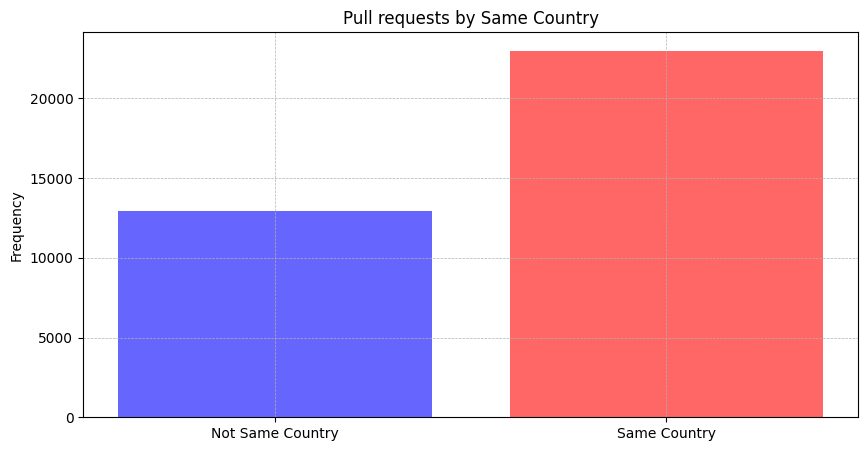

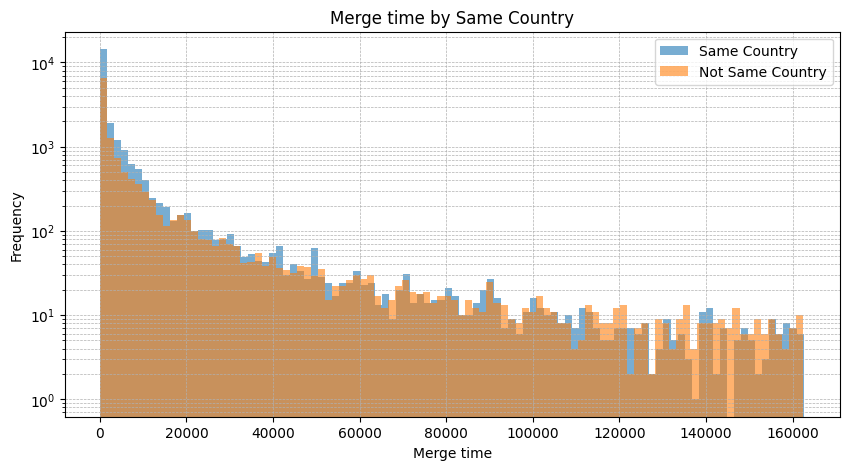

Shapiro-Wilk test for same country: W = 0.7998122576965064, p = 0.11405017120604721
Shapiro-Wilk test for not same country: W = 0.7520312910693271, p = 0.004485737161479042
Kruskal-Wallis H test: H = 647.4616582718644, p = 7.964382764386867e-143
Spearman correlation for male contributors, mergetime: rho = 0.053651765392292314, p = 3.9762798462684886e-16
Spearman correlation for same country, mergetime (log): rho = 0.053651765392292314, p = 3.9762798462684886e-16
Spearman correlation for different country, mergetime: rho = 0.03538858951347666, p = 5.767896100472288e-05
Spearman correlation for different country, mergetime (log): rho = 0.03538858951347666, p = 5.767896100472288e-05
Mean merge time for same country: 7016.745953706926
Mean merge time for not same country: 11465.46615551425
Median merge time for same country: 1009.0
Median merge time for not same country: 1559.5
Standard deviation of merge time for same country: 18517.969811393345
Standard deviation of merge time for not sa

In [187]:
same_country = merged_data['same_country'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(same_country.index, same_country.values, alpha=0.6, color=['blue', 'red'])
plt.xticks(same_country.index, ['Not Same Country', 'Same Country'])
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Pull requests by Same Country')
plt.show()

same_country = merged_data[merged_data['same_country'] == 1]
not_same_country = merged_data[merged_data['same_country'] == 0]

plt.figure(figsize=(10, 5))
plt.hist(same_country['mergetime_minutes'], bins=100, alpha=0.6, label='Same Country', log=True)
plt.hist(not_same_country['mergetime_minutes'], bins=100, alpha=0.6, label='Not Same Country', log=True)
plt.xlabel('Merge time')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Merge time by Same Country')
plt.show()

same_country_sample = same_country['mergetime_minutes'].sample(n=3, random_state=1)
not_same_country_sample = not_same_country['mergetime_minutes'].sample(n=3,random_state=1)

res_same_country = shapiro(same_country_sample)
res_not_same_country = shapiro(not_same_country_sample)
print('Shapiro-Wilk test for same country: W = {}, p = {}'.format(res_same_country.statistic, res_same_country.pvalue))
print('Shapiro-Wilk test for not same country: W = {}, p = {}'.format(res_not_same_country.statistic, res_not_same_country.pvalue))

H, p = kruskal(same_country['mergetime_minutes'], not_same_country['mergetime_minutes'])
print('Kruskal-Wallis H test: H = {}, p = {}'.format(H, p))

spearman_same = spearmanr(same_country['mergetime_minutes'], same_country['doc_files'])
print('Spearman correlation for male contributors, mergetime: rho = {}, p = {}'.format(spearman_same.statistic, spearman_same.pvalue))
spearman_same_log = spearmanr(same_country['log_mergetime_minutes'], same_country['doc_files'])
print('Spearman correlation for same country, mergetime (log): rho = {}, p = {}'.format(spearman_same_log.statistic, spearman_same_log.pvalue))

spearman_not_same = spearmanr(not_same_country['mergetime_minutes'], not_same_country['doc_files'])
print('Spearman correlation for different country, mergetime: rho = {}, p = {}'.format(spearman_not_same.statistic, spearman_not_same.pvalue))
spearman_not_same_log = spearmanr(not_same_country['log_mergetime_minutes'], not_same_country['doc_files'])
print('Spearman correlation for different country, mergetime (log): rho = {}, p = {}'.format(spearman_not_same_log.statistic, spearman_not_same_log.pvalue))

print('Mean merge time for same country: {}'.format(same_country['mergetime_minutes'].mean()))
print('Mean merge time for not same country: {}'.format(not_same_country['mergetime_minutes'].mean()))
print('Median merge time for same country: {}'.format(same_country['mergetime_minutes'].median()))
print('Median merge time for not same country: {}'.format(not_same_country['mergetime_minutes'].median()))
print('Standard deviation of merge time for same country: {}'.format(same_country['mergetime_minutes'].std()))
print('Standard deviation of merge time for not same country: {}'.format(not_same_country['mergetime_minutes'].std()))
print('Maximum merge time for same country: {}'.format(same_country['mergetime_minutes'].max()))
print('Maximum merge time for not same country: {}'.format(not_same_country['mergetime_minutes'].max()))
print('Minimum merge time for same country: {}'.format(same_country['mergetime_minutes'].min()))
print('Minimum merge time for not same country: {}'.format(not_same_country['mergetime_minutes'].min()))

# Affiliation

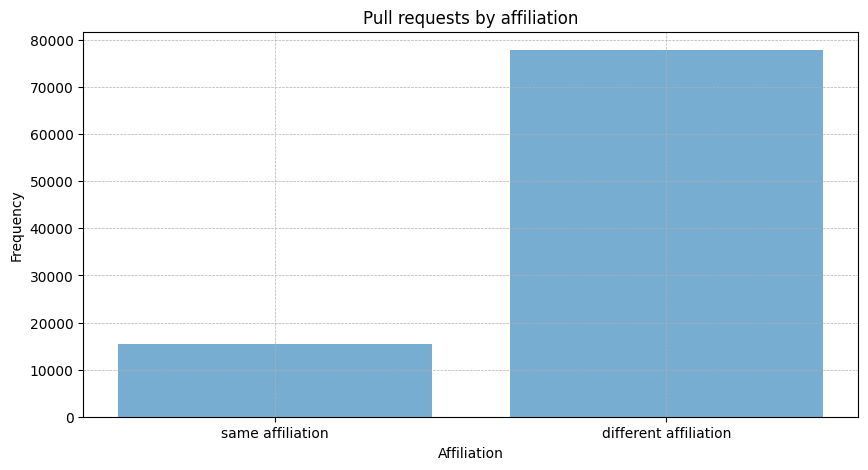

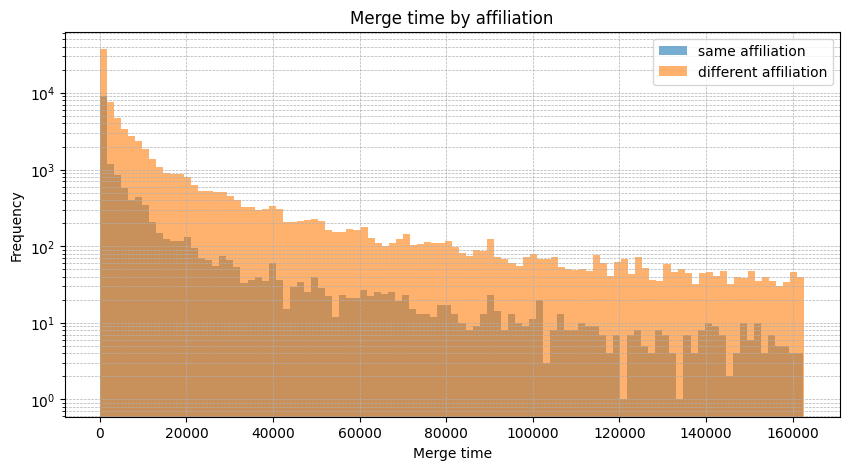

Shapiro-Wilk test for same affiliation: W = 0.4530539983527778, p = 4.216614271471113e-82
Shapiro-Wilk test for different affiliation: W = 0.5133877011092051, p = 1.455708894642318e-79
Kruskal-Wallis H test: H = 912.4945632948851, p = 1.886572375121312e-200
Spearman correlation for same affiliation, mergetime: rho = 0.09906557803433502, p = 3.7528454413189964e-35
Spearman correlation for same affiliation, mergetime (log): rho = 0.09906557803433502, p = 3.7528454413189964e-35
Spearman correlation for different affiliation, mergetime: rho = 0.03838918957636282, p = 8.638253559686287e-27
Spearman correlation for different affiliation, mergetime (log): rho = 0.03838918957636282, p = 8.638253559686287e-27
Mean merge time for same affiliation: 8764.721842783505
Mean merge time for different affiliation: 11948.793495433702
Median merge time for same affiliation: 1148.0
Median merge time for different affiliation: 1891.0
Standard deviation of merge time for same affiliation: 21609.4359383868
S

In [188]:
same_affiliation = merged_data[merged_data['contrib_affiliation'] == merged_data['inte_affiliation']]
diff_affiliation = merged_data[merged_data['contrib_affiliation'] != merged_data['inte_affiliation']]

plt.figure(figsize=(10, 5))
plt.bar(['same affiliation', 'different affiliation'], [len(same_affiliation), len(diff_affiliation)], alpha=0.6)
plt.xlabel('Affiliation')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Pull requests by affiliation')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(same_affiliation['mergetime_minutes'], bins=100, alpha=0.6, label='same affiliation', log=True)
plt.hist(diff_affiliation['mergetime_minutes'], bins=100, alpha=0.6, label='different affiliation', log=True)
plt.xlabel('Merge time')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Merge time by affiliation')
plt.show()

sample_size = 5000
same_sample = same_affiliation['mergetime_minutes'].sample(n=sample_size, random_state=1)
diff_sample = diff_affiliation['mergetime_minutes'].sample(n=sample_size, random_state=1)

res_same = shapiro(same_sample)
res_diff = shapiro(diff_sample)
print('Shapiro-Wilk test for same affiliation: W = {}, p = {}'.format(res_same.statistic, res_same.pvalue))
print('Shapiro-Wilk test for different affiliation: W = {}, p = {}'.format(res_diff.statistic, res_diff.pvalue))

H, p = kruskal(same_affiliation['mergetime_minutes'], diff_affiliation['mergetime_minutes'])
print('Kruskal-Wallis H test: H = {}, p = {}'.format(H, p))

spearman_same = spearmanr(same_affiliation['mergetime_minutes'], same_affiliation['doc_files'])
print('Spearman correlation for same affiliation, mergetime: rho = {}, p = {}'.format(spearman_same.statistic, spearman_same.pvalue))
spearman_same_log = spearmanr(same_affiliation['log_mergetime_minutes'], same_affiliation['doc_files'])
print('Spearman correlation for same affiliation, mergetime (log): rho = {}, p = {}'.format(spearman_same_log.statistic, spearman_same_log.pvalue))

spearman_not_same = spearmanr(diff_affiliation['mergetime_minutes'], diff_affiliation['doc_files'])
print('Spearman correlation for different affiliation, mergetime: rho = {}, p = {}'.format(spearman_not_same.statistic, spearman_not_same.pvalue))
spearman_not_same_log = spearmanr(diff_affiliation['log_mergetime_minutes'], diff_affiliation['doc_files'])
print('Spearman correlation for different affiliation, mergetime (log): rho = {}, p = {}'.format(spearman_not_same_log.statistic, spearman_not_same_log.pvalue))


print('Mean merge time for same affiliation: {}'.format(same_affiliation['mergetime_minutes'].mean()))
print('Mean merge time for different affiliation: {}'.format(diff_affiliation['mergetime_minutes'].mean()))
print('Median merge time for same affiliation: {}'.format(same_affiliation['mergetime_minutes'].median()))
print('Median merge time for different affiliation: {}'.format(diff_affiliation['mergetime_minutes'].median()))
print('Standard deviation of merge time for same affiliation: {}'.format(same_affiliation['mergetime_minutes'].std()))
print('Standard deviation of merge time for different affiliation: {}'.format(diff_affiliation['mergetime_minutes'].std()))
print('Maximum merge time for same affiliation: {}'.format(same_affiliation['mergetime_minutes'].max()))
print('Maximum merge time for different affiliation: {}'.format(diff_affiliation['mergetime_minutes'].max()))
print('Minimum merge time for same affiliation: {}'.format(same_affiliation['mergetime_minutes'].min()))
print('Minimum merge time for different affiliation: {}'.format(diff_affiliation['mergetime_minutes'].min()))

# Team dynamics

number of different project ids: 13


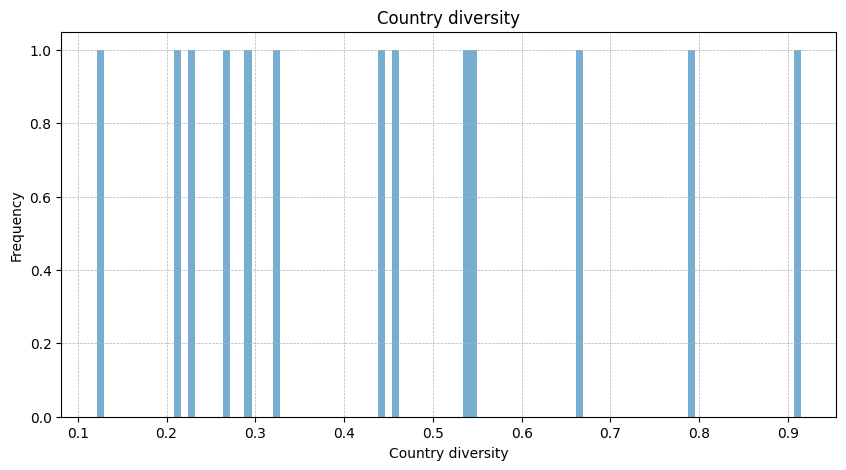

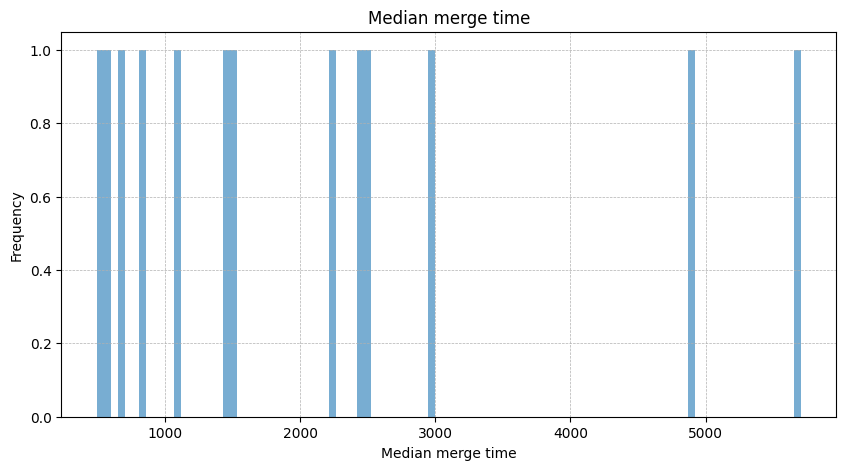

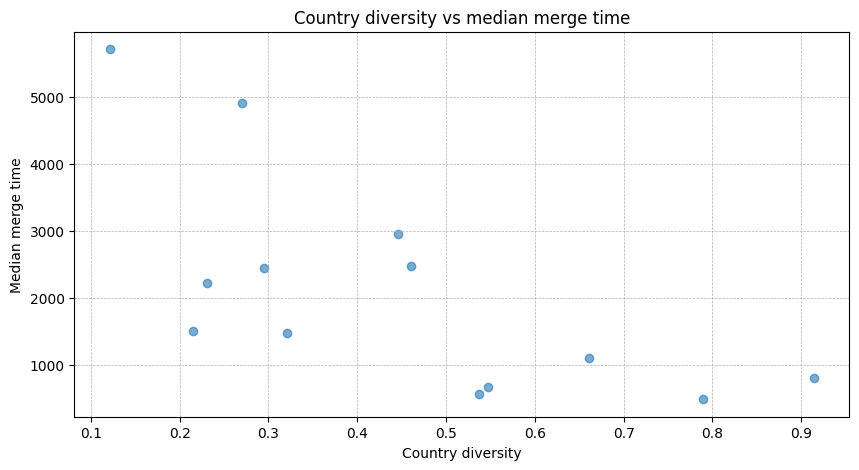

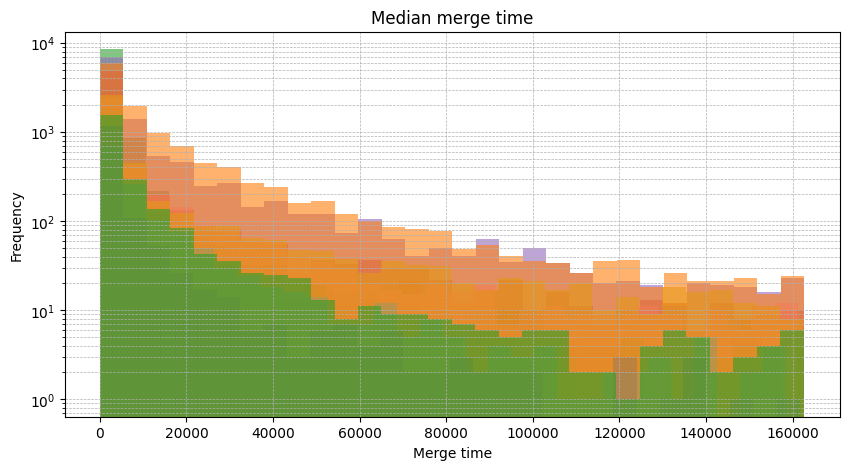

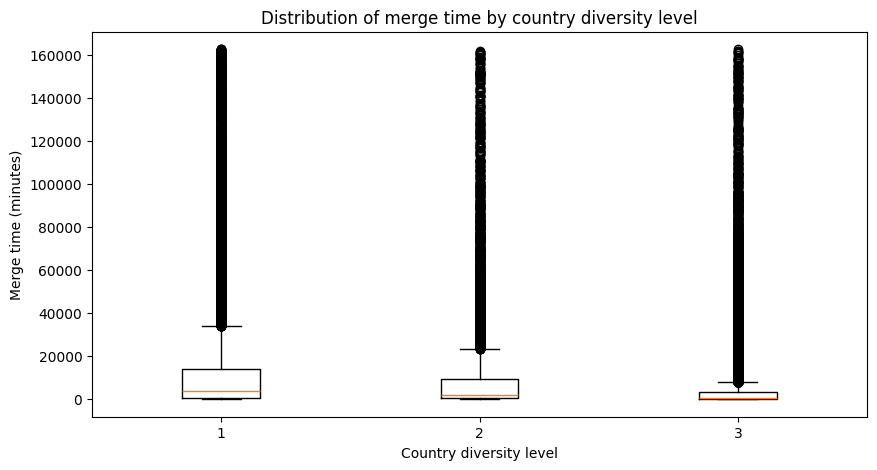

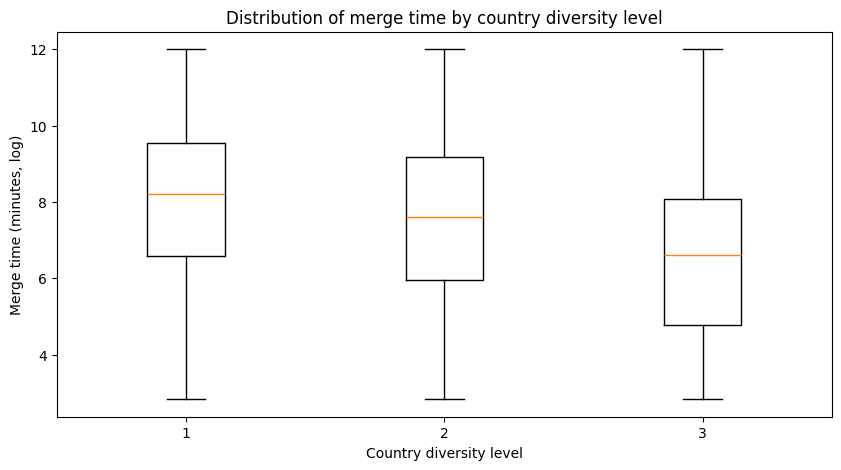

Kruskal-Wallis Test: Stat=5293.329757138476, P-value=0.0
Mann-Whitney U Test between Low and High Diversity: Stat=493057856.0, P-value=0.0
Mean merge time for low diversity: 14143.356001153144
Mean merge time for medium diversity: 11158.610654458433
Mean merge time for high diversity: 5874.555014647596
Median merge time for low diversity: 3644.0
Median merge time for medium diversity: 1996.0
Median merge time for high diversity: 733.0
Standard deviation of merge time for low diversity: 25818.827177104406
Standard deviation of merge time for medium diversity: 23548.001991506513
Standard deviation of merge time for high diversity: 16997.404136843452
Maximum merge time for low diversity: 162737.0
Maximum merge time for medium diversity: 161932.0
Maximum merge time for high diversity: 162714.0
Minimum merge time for low diversity: 16.0
Minimum merge time for medium diversity: 16.0
Minimum merge time for high diversity: 16.0


In [189]:
core_team = merged_data[merged_data['core_member'] == 1]
print('number of different project ids: {}'.format(len(core_team['project_id'].unique())))
core_team_merge_time = core_team.groupby('project_id').agg({
    'contrib_country': 'nunique',
    'mergetime_minutes': 'median',
    'team_size': 'mean'
}).rename(columns={'contrib_country': 'country_diversity', 'mergetime_minutes': 'median_mergetime_minutes', 'team_size': 'avg_team_size'})
core_team_merge_time['relative_country_diversity'] = core_team_merge_time['country_diversity'] / core_team_merge_time['avg_team_size']
grouped = core_team.groupby('project_id')

plt.figure(figsize=(10, 5))
plt.hist(core_team_merge_time['relative_country_diversity'], bins=100, alpha=0.6)
plt.xlabel('Country diversity')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Country diversity')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(core_team_merge_time['median_mergetime_minutes'], bins=100, alpha=0.6)
plt.xlabel('Median merge time')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Median merge time')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(core_team_merge_time['relative_country_diversity'], core_team_merge_time['median_mergetime_minutes'], alpha=0.6)
plt.xlabel('Country diversity')
plt.ylabel('Median merge time')
plt.title('Country diversity vs median merge time')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

plt.figure(figsize=(10, 5))
for id, group in grouped:
    plt.hist(group['mergetime_minutes'], bins=30, alpha=0.6, log=True)
plt.xlabel('Merge time')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Median merge time')
plt.show()


quantile_labels = ['Low', 'Medium', 'High']
core_team_merge_time['diversity_level'] = pd.qcut(core_team_merge_time['relative_country_diversity'], q=3, labels=quantile_labels)
core_team = core_team.merge(core_team_merge_time['diversity_level'], on='project_id', how='left')

times_low = core_team[core_team['diversity_level'] == 'Low']['mergetime_minutes']
times_medium = core_team[core_team['diversity_level'] == 'Medium']['mergetime_minutes']
times_high = core_team[core_team['diversity_level'] == 'High']['mergetime_minutes']

times_low_log = core_team[core_team['diversity_level'] == 'Low']['log_mergetime_minutes']
times_medium_log = core_team[core_team['diversity_level'] == 'Medium']['log_mergetime_minutes']
times_high_log = core_team[core_team['diversity_level'] == 'High']['log_mergetime_minutes']

plt.figure(figsize=(10, 5))
plt.boxplot([times_low, times_medium, times_high], data=core_team)
plt.xlabel('Country diversity level')
plt.ylabel('Merge time (minutes)')
plt.title('Distribution of merge time by country diversity level')
plt.show()

plt.figure(figsize=(10, 5))
plt.boxplot([times_low_log, times_medium_log, times_high_log], data=core_team)
plt.xlabel('Country diversity level')
plt.ylabel('Merge time (minutes, log)')
plt.title('Distribution of merge time by country diversity level')
plt.show()

stat, p = kruskal(times_low, times_medium, times_high)
print(f"Kruskal-Wallis Test: Stat={stat}, P-value={p}")

stat, p = mannwhitneyu(times_low, times_high)
print(f"Mann-Whitney U Test between Low and High Diversity: Stat={stat}, P-value={p}")

print('Mean merge time for low diversity: {}'.format(times_low.mean()))
print('Mean merge time for medium diversity: {}'.format(times_medium.mean()))
print('Mean merge time for high diversity: {}'.format(times_high.mean()))
print('Median merge time for low diversity: {}'.format(times_low.median()))
print('Median merge time for medium diversity: {}'.format(times_medium.median()))
print('Median merge time for high diversity: {}'.format(times_high.median()))
print('Standard deviation of merge time for low diversity: {}'.format(times_low.std()))
print('Standard deviation of merge time for medium diversity: {}'.format(times_medium.std()))
print('Standard deviation of merge time for high diversity: {}'.format(times_high.std()))
print('Maximum merge time for low diversity: {}'.format(times_low.max()))
print('Maximum merge time for medium diversity: {}'.format(times_medium.max()))
print('Maximum merge time for high diversity: {}'.format(times_high.max()))
print('Minimum merge time for low diversity: {}'.format(times_low.min()))
print('Minimum merge time for medium diversity: {}'.format(times_medium.min()))
print('Minimum merge time for high diversity: {}'.format(times_high.min()))